# **Travel Insurance**

# **Business Understanding**

Context

Travel insurance is a type of insurance that provides protection as long as we travel both domestically and abroad. Several countries have even required travelers to have travel insurance, for example, countries in Europe and America. The amount of premium depends on the coverage desired, the length of the trip, and the purpose of the trip. A company engaged in travel insurance wants to know the policyholder who will submit an insurance claim for coverage. Policyholder data at insurance companies is historical data consisting of destinations, insurance products, and so on.

Target :

0: Did not submit insurance claim

1: Submit Insurance Claim

## Problem Statement
Processing insurance claims is a resource-intensive task. The company wants to improve its operational efficiency by identifying which customers are most likely to submit claims. This will allow them to allocate resources more effectively and manage risk more efficiently.

Additionally, understanding the factors that contribute to a customer's likelihood of submitting a claim will enable the company to tailor its insurance products and services better, potentially reducing the number of claims or managing them more effectively.

## Goals
The goal is to develop a predictive model that can classify whether a policyholder is likely to submit an insurance claim based on historical data. This model will help the company focus its resources on high-risk customers, optimize premium pricing, and enhance customer service.

Furthermore, the company seeks to understand the key factors that influence a customer's decision to submit a claim. This knowledge will allow the company to make informed decisions about product offerings, customer engagement strategies, and risk management.

## Analytic Approach
To address the business problem, the following steps will be taken:

- Exploratory Data Analysis (EDA): Analyze the historical data to identify patterns and trends that distinguish customers who submit claims from those who do not.
- Feature Engineering: Identify and create features that are most predictive of a customer's likelihood to submit a claim.
- Model Building: Develop a classification model to predict the probability of a customer submitting an insurance claim.
- Model Evaluation: Evaluate the model's performance using metrics such as ROC-AUC, Precision, and Recall to ensure that the model balances the - trade-off between false positives and false negatives.


## Final Goal
The final goal is to implement a classification model that helps the company efficiently predict and manage claims while also gaining insights into the key factors driving these claims. This will enable the company to reduce costs, improve risk management, and offer better-targeted insurance products to its customers.

### **Data Understanding**

| Attribute                | Data Type       | Description                                                           |
|--------------------------|-----------------|-----------------------------------------------------------------------|
| Agency                   | Object            | Name of the travel insurance agency                                   |
| Agency Type              | Object            | Type of travel insurance agency (e.g., Airlines, Travel Agency)       |
| Distribution Channel     | Object            | Channel used by the agency to distribute the insurance (e.g., Online, Offline) |
| Product Name             | Object            | Name of the travel insurance product purchased                        |
| Gender                   | Object            | Gender of the insured person (M, F)                                   |
| Duration                 | Integer         | Duration of travel in days                                            |
| Destination              | Object            | Travel destination of the insured person                              |
| Net Sales                | Float           | Amount of sales generated by the travel insurance policy              |
| Commision (in value)     | Float           | Commission earned by the agency for the insurance policy              |
| Age                      | Integer         | Age of the insured person                                             |
| Claim                    | Object            | Claim status (Yes, No) indicating whether a claim was made against the policy |


In [2690]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display
import statsmodels.api as sm
import plotly.express as px

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from scipy.stats import chi2_contingency


# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from category_encoders import BinaryEncoder
from collections import Counter


# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [2691]:
#Load Dataset
df = pd.read_csv("data_travel_insurance.csv")
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


### Exploratory Data Exploration (EDA)

In [2692]:
# Count and Datatype for each Column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


In [2693]:
df.isna().sum()/len(df.index)*100

Agency                   0.000000
Agency Type              0.000000
Distribution Channel     0.000000
Product Name             0.000000
Gender                  71.392799
Duration                 0.000000
Destination              0.000000
Net Sales                0.000000
Commision (in value)     0.000000
Age                      0.000000
Claim                    0.000000
dtype: float64

In [2694]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Agency,object,0,0.00,16,"[JZI, CWT]"
1,Agency Type,object,0,0.00,2,"[Travel Agency, Airlines]"
2,Distribution Channel,object,0,0.00,2,"[Online, Offline]"
3,Product Name,object,0,0.00,26,"[Travel Cruise Protect Family, Annual Travel P..."
4,Gender,object,31647,71.39,2,"[M, nan]"
5,Duration,int64,0,0.00,437,"[367, 250]"
6,Destination,object,0,0.00,138,"[SWEDEN, BHUTAN]"
7,Net Sales,float64,0,0.00,1006,"[-148.5, 288.5]"
8,Commision (in value),float64,0,0.00,915,"[25.55, 0.75]"
9,Age,int64,0,0.00,89,"[22, 35]"


In [2695]:
df['Gender'].unique()

array(['F', nan, 'M'], dtype=object)

In [2696]:
df.describe()

,Duration,Net Sales,Commision (in value),Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600
std,109.153961,48.661970,19.625637,13.954926
min,-1.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


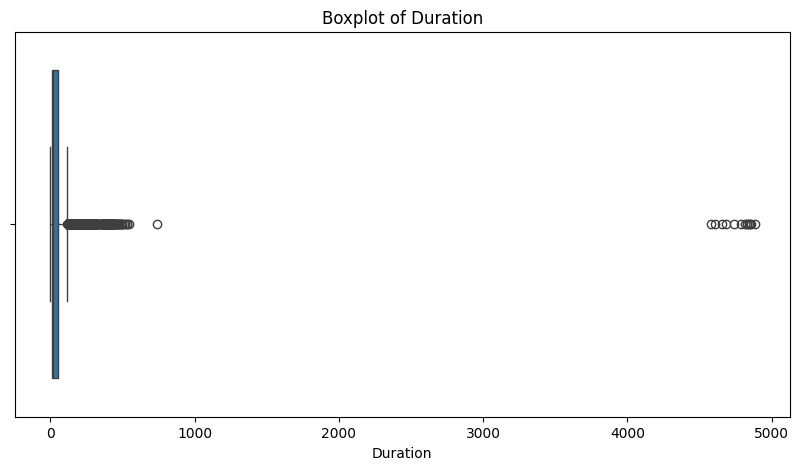

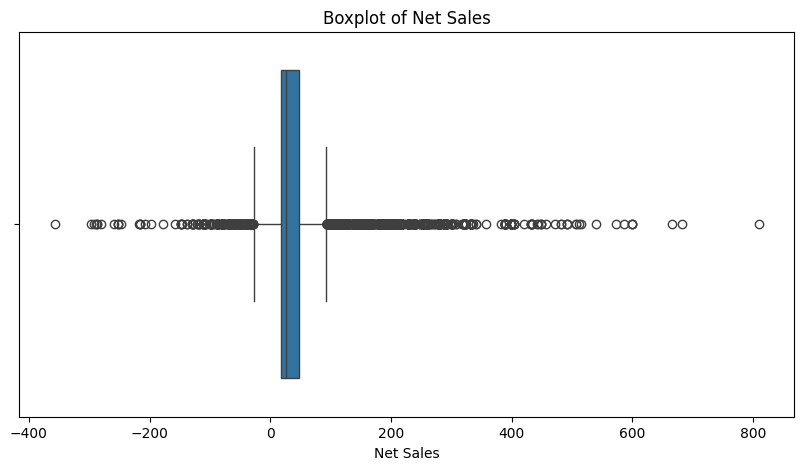

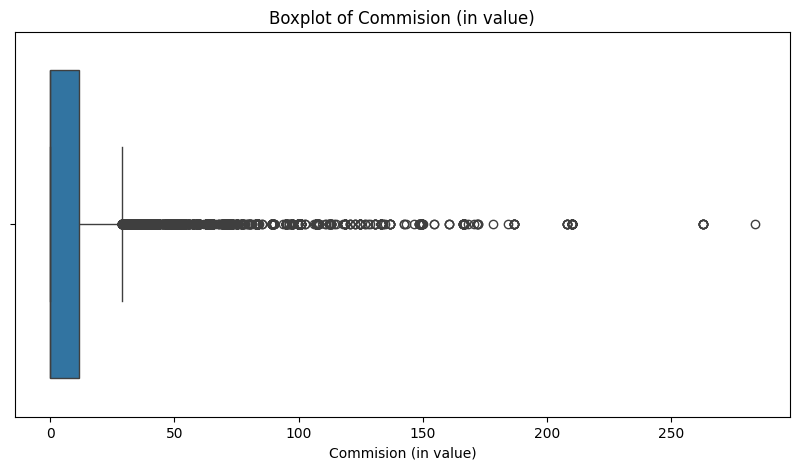

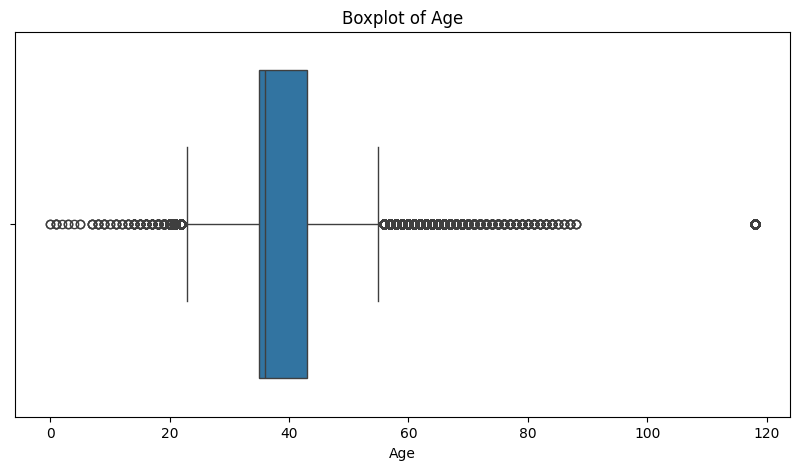

In [2698]:
# Boxplot to detect outliers in numerical features
numerical_features = ['Duration', 'Net Sales', 'Commision (in value)', 'Age']

for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()


Kita bisa melihat bahwa ada outlier yang extreme terjadi pada, Duration dan Age

In [2699]:
# Misalkan kita ingin melihat outlier untuk kolom 'Net Sales'
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Inisialisasi dictionary untuk menyimpan persentase outlier
outlier_percentages = {}

for column in numeric_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Menghitung jumlah outlier
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    num_outliers = outliers.shape[0]

    # Menghitung persentase outlier
    total_data = df.shape[0]
    percentage_outliers = (num_outliers / total_data) * 100

    # Menyimpan hasil dalam dictionary
    outlier_percentages[column] = percentage_outliers

# Mengonversi hasil ke DataFrame untuk visualisasi atau penyimpanan
outlier_df = pd.DataFrame.from_dict(outlier_percentages, orient='index', columns=['Outlier Percentage'])

# Menampilkan hasil
print(outlier_df)

                      Outlier Percentage
Duration                        8.728118
Net Sales                       8.750677
Commision (in value)           11.074265
Age                            11.721711


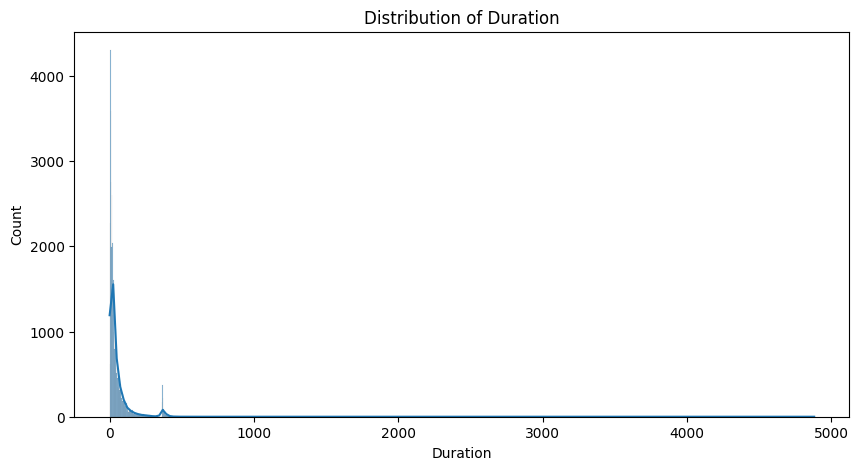

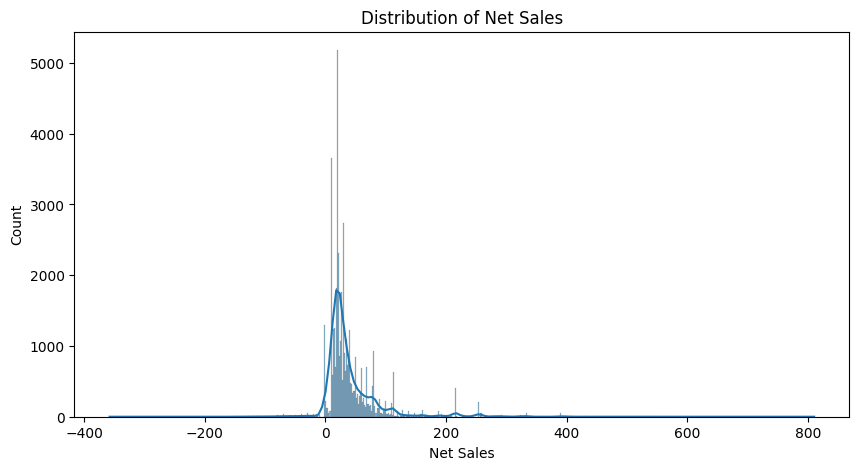

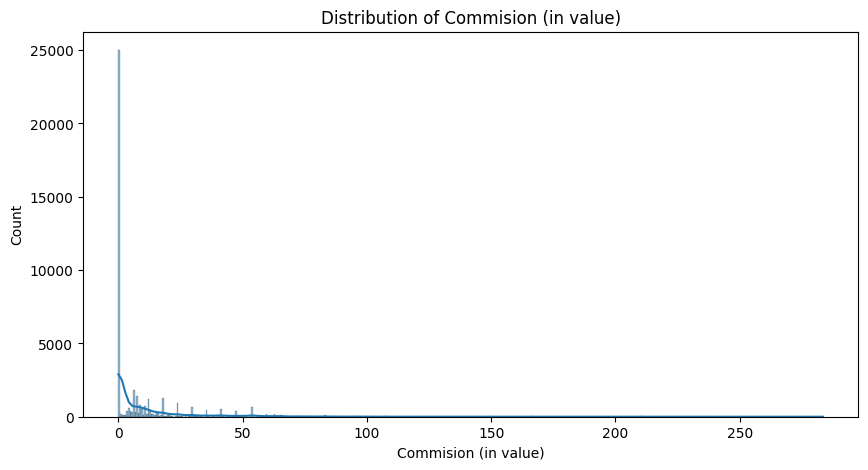

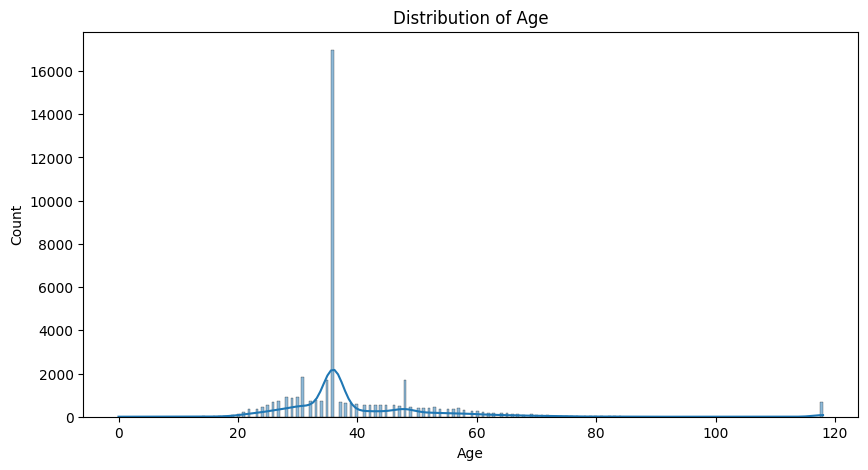

In [2700]:
# Distribution of numerical features
for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()


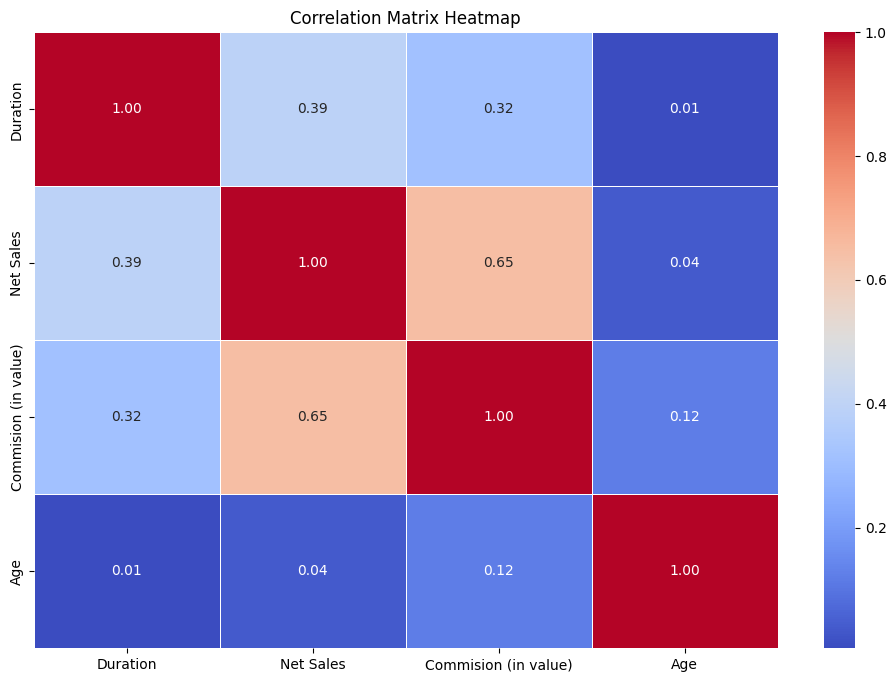

In [2701]:
# Select only numeric columns from the data
numeric_data = df.select_dtypes(include=['number'])

# Calculate the correlation matrix on numeric data only
correlation_matrix = numeric_data.corr()

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


### **Data Cleaning**  

In [2702]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


In [2703]:
df.isna().sum()/len(df.index)*100

Agency                   0.000000
Agency Type              0.000000
Distribution Channel     0.000000
Product Name             0.000000
Gender                  71.392799
Duration                 0.000000
Destination              0.000000
Net Sales                0.000000
Commision (in value)     0.000000
Age                      0.000000
Claim                    0.000000
dtype: float64

In [2704]:
duplicate_rows = df.duplicated().sum()
duplicate_rows


4667

In [2705]:
df.drop_duplicates()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No


Di sini saya melakukan drop duplicates untuk mengoptimalkan data agar menghapus data-data yang bersifat duplicate

### **Bar Plot**


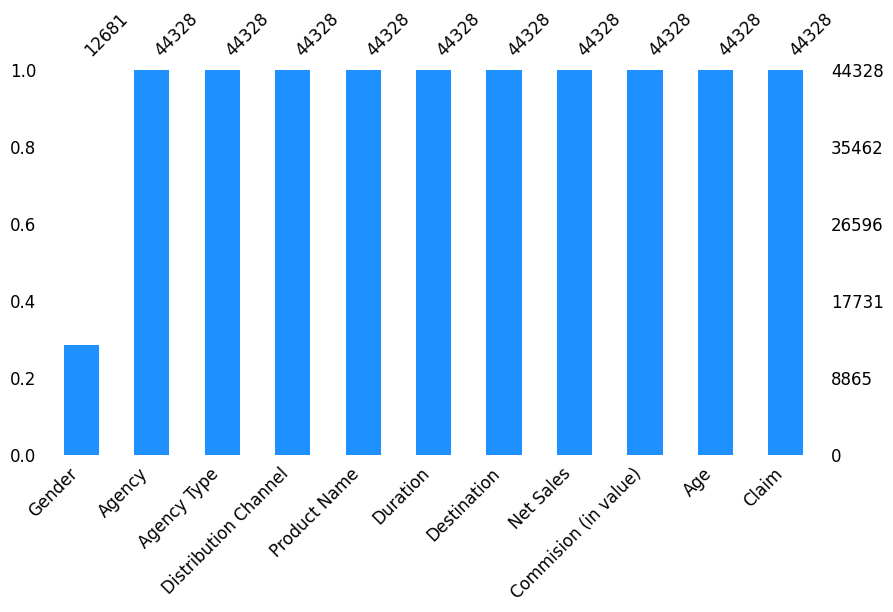

In [2706]:
missingno.bar(df,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

Terlihat dari Bar Plot tersebut, bahwa kolom hanya Gender memiliki missing values/data yang hilang. 

Kemudian berdasarkan Bar Plot tersebut juga, kolom Gender adalah kolom yang memiliki Missing Value yang cukup banyak

### **Matrix Plot**

<Axes: >

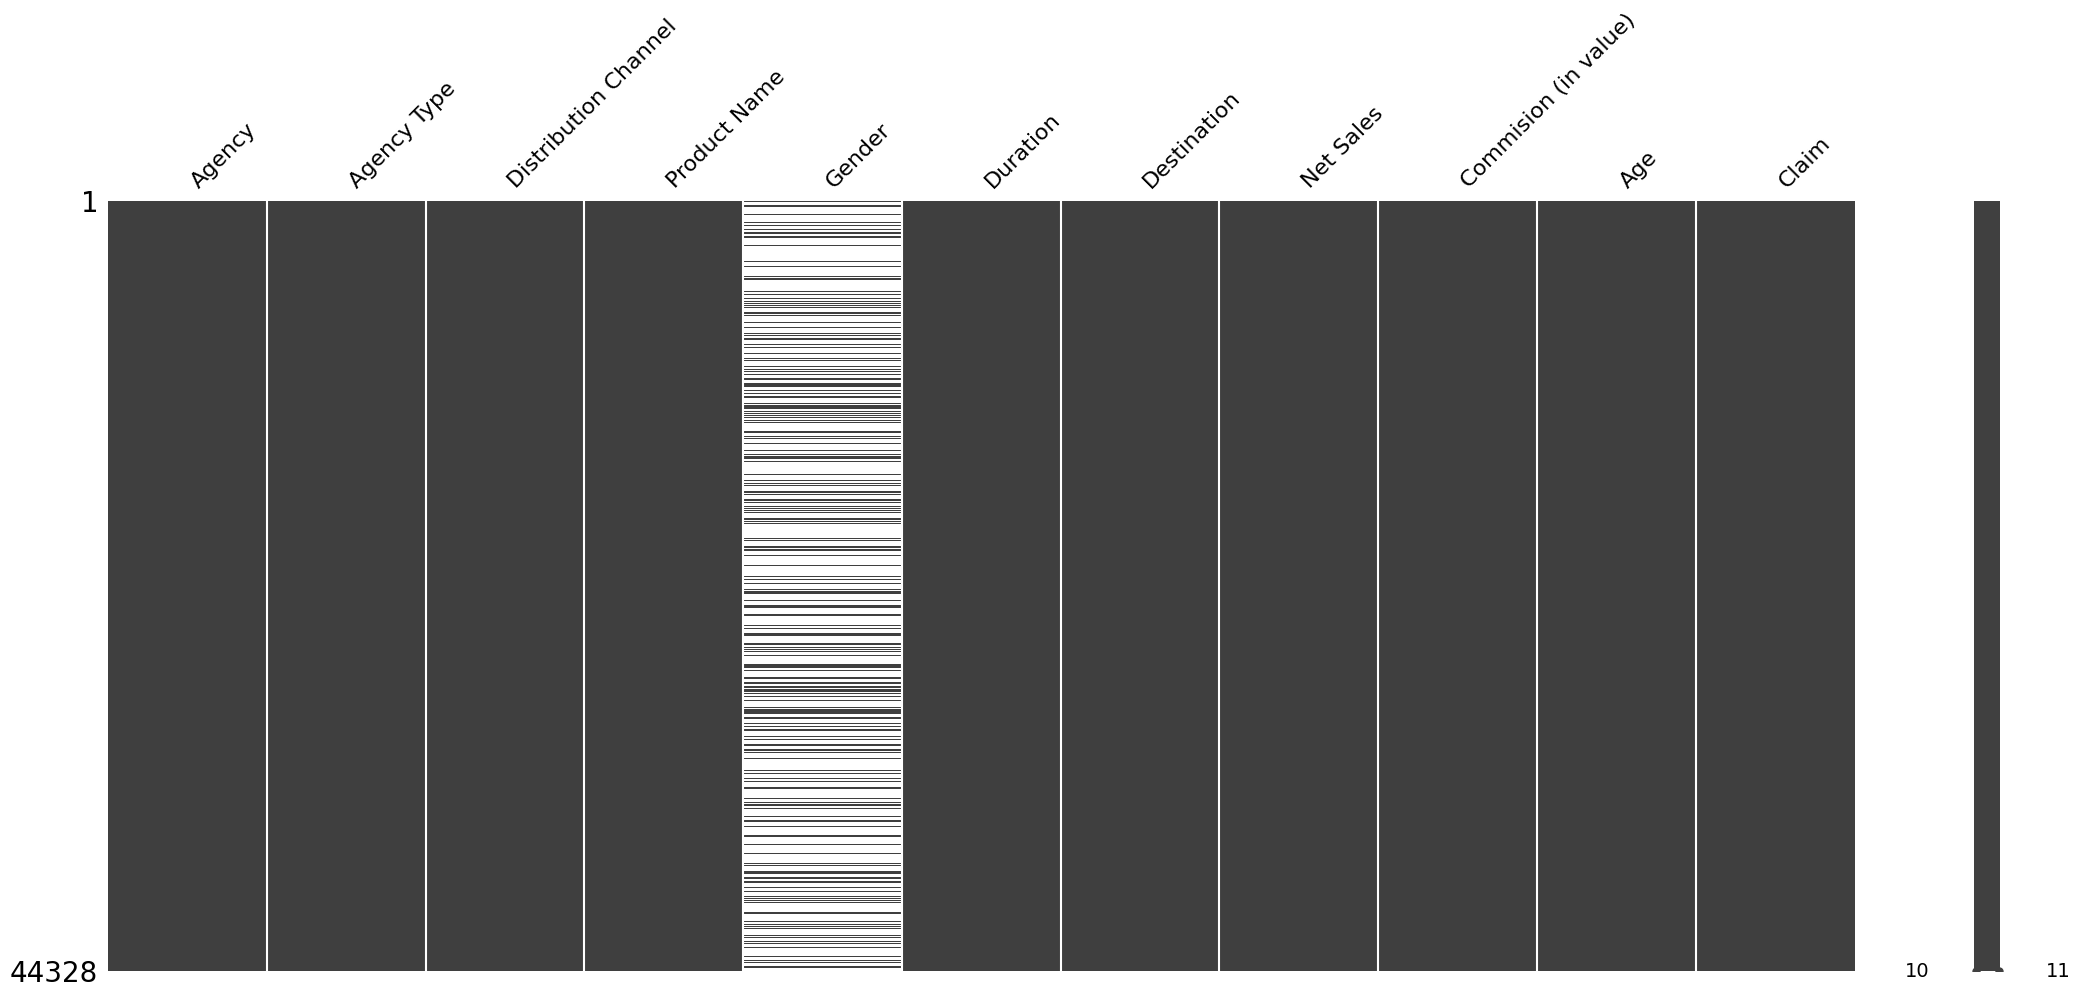

In [2707]:
missingno.matrix(df)

Terlihat bahwa missing value/data yang hilang pada kolom Gender cukup banyak yang hampir memenuhi plot di atas.

### **Dendogram**

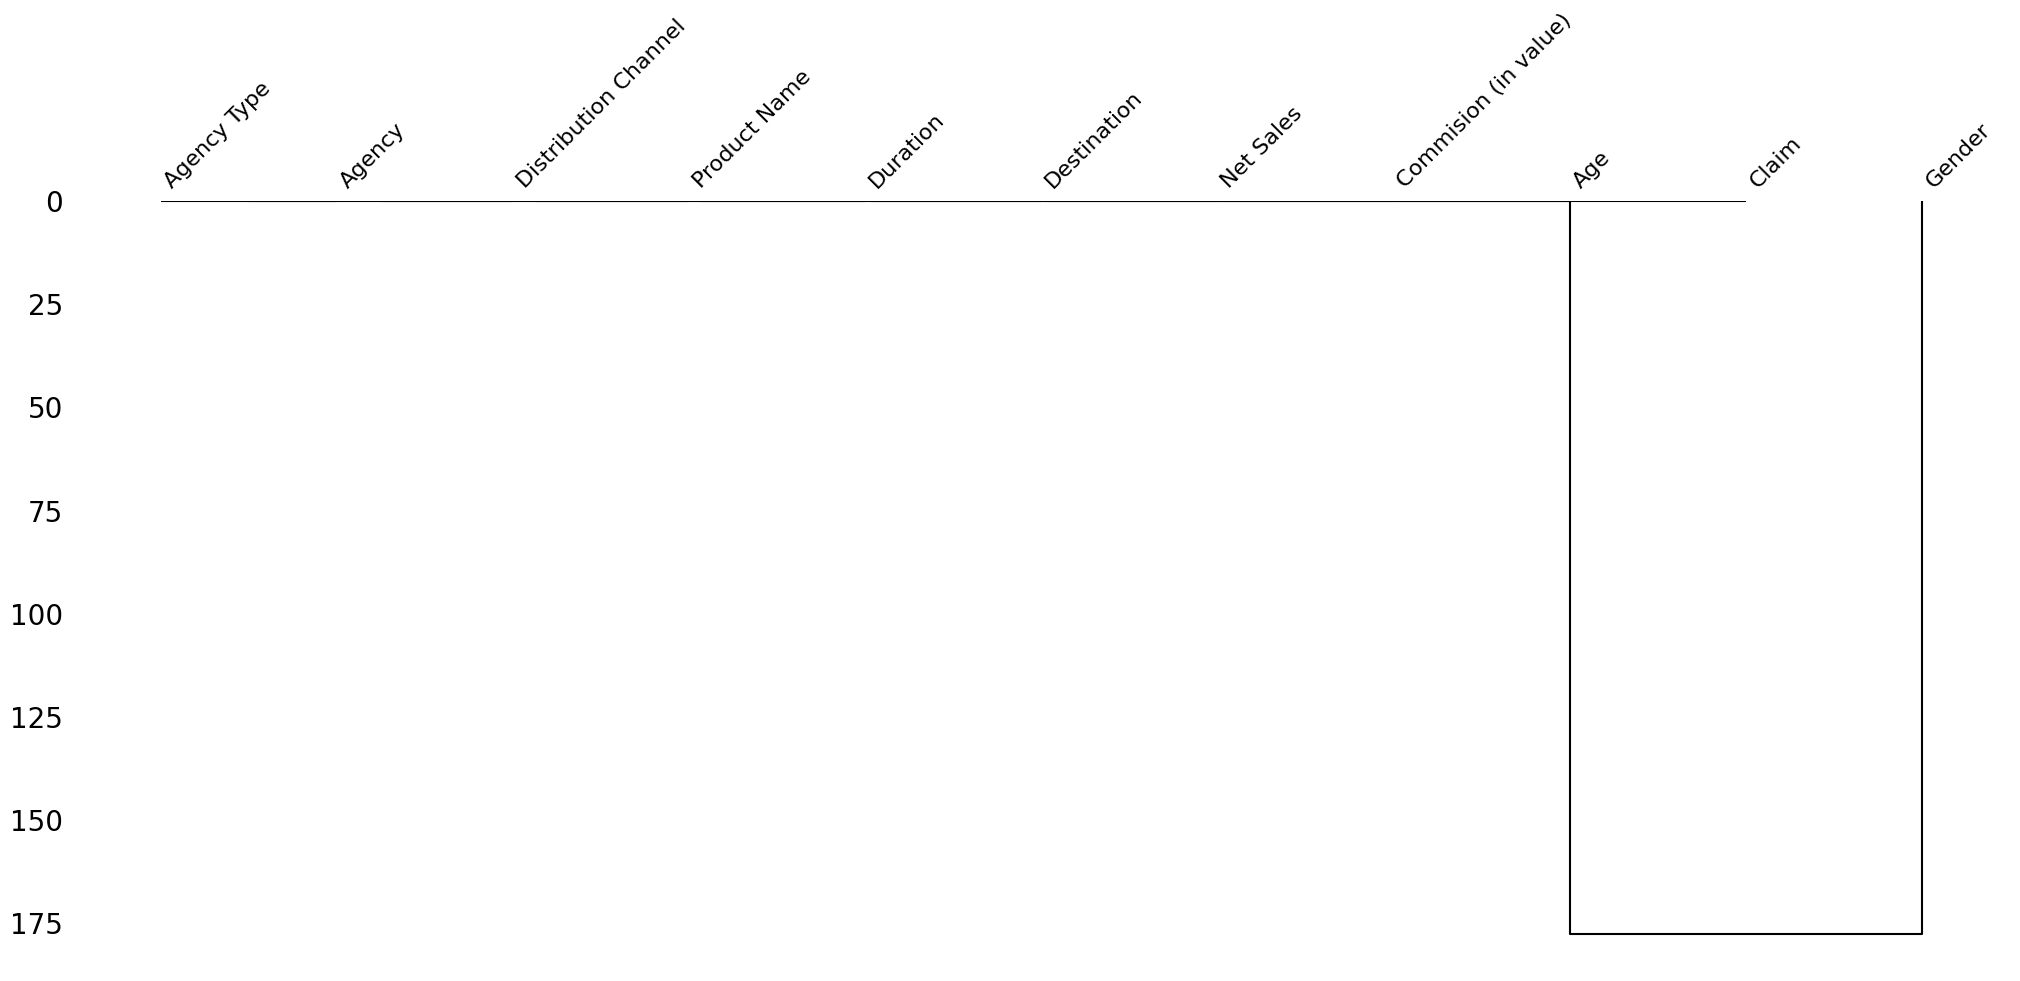

In [2708]:
missingno.dendrogram(df)
plt.show()

Berdasarkan dendogram tersebut, terlihat bahwa benar kolom Gender dan Age memang cukup berkorelasi dari segi missing values/datanya. Kemudian kolom target, training_hours, relevent_experience, city, dan city_development_index berada di titik 0 karena mereka tidak mempunyai missing values/data.

- Kita Bisa melihat bawa Missing value pada kolom Gender memiliki jumlah missing value sebanyak 71% kurang lebih, dan kita juga bisa melihat bahwa column gender cukup berkorelasi dengan kolom age. 
- Maka Dari itu penanganan yang tepat untuk menghilangkan missinng value adalah dengan melakukan Predictive Imputation

In [2709]:
df['Gender'].unique()

array(['F', nan, 'M'], dtype=object)

In [2710]:
df['Gender'].value_counts(normalize=True)


Gender
M    0.512893
F    0.487107
Name: proportion, dtype: float64

Sebelumnya kita bisa melihat bahwa mayoritas column gender di isi dengan missing value atau NaN, yang kurang lebih mencapai 71% missing value. dan kita bisa lihat bahwa distribusi untuk Male Dan Female sangat sedikit. maka untuk membersihkan missing value saya melakukan drop column untuk column gender, karena memiliki jumlah missing value yang cukup banyak yang membuat kolom tersebut tidak terlalu informatif

In [2711]:
df.drop(columns=['Gender'], axis = 1, inplace= True)

In [2712]:
df[df['Age'] > 100]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
99,ART,Airlines,Online,Value Plan,7,MALAYSIA,29.0,10.15,118,No
105,JZI,Airlines,Offline,Basic Plan,16,INDONESIA,37.0,12.95,118,No
363,JWT,Airlines,Online,Value Plan,12,INDIA,39.0,15.60,118,No
373,JWT,Airlines,Online,Value Plan,6,INDIA,39.0,15.60,118,No
727,JWT,Airlines,Online,Value Plan,76,INDIA,100.0,40.00,118,No
...,...,...,...,...,...,...,...,...,...,...
44089,JWT,Airlines,Online,Value Plan,42,INDIA,31.0,12.40,118,No
44140,JWT,Airlines,Online,Value Plan,84,INDIA,93.0,37.20,118,No
44150,JWT,Airlines,Online,Value Plan,5,INDIA,39.0,15.60,118,No
44160,JWT,Airlines,Online,Value Plan,0,INDIA,31.0,12.40,118,No


Seperti yang kita bisa lihat di boxplot di atas untuk Age, bahwa ada umur customer yang di atas 100 tahun yang menunjukan adanya ketidakmungkinan atau jarang terjadi pada business insurance, dimana hal ini jarang terjadi karena jarang ada case bahwa insurance mendapatkan claim dari yang berumur 100 tahun.

In [2713]:
df = df[df['Age'] <= 100]

# Memeriksa jumlah baris setelah penghapusan
print(f"Jumlah baris setelah penghapusan: {df.shape[0]}")


Jumlah baris setelah penghapusan: 43652


In [2714]:
df[df['Duration']>740]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
87,SSI,Airlines,Online,Ticket Protector,4736,SINGAPORE,0.32,0.09,48,No
4678,SSI,Airlines,Online,Ticket Protector,4857,SINGAPORE,0.32,0.09,48,No
10172,SSI,Airlines,Online,Ticket Protector,4815,SINGAPORE,0.32,0.09,48,No
12140,SSI,Airlines,Online,Ticket Protector,4652,SINGAPORE,0.32,0.09,48,No
19497,SSI,Airlines,Online,Ticket Protector,4881,SINGAPORE,0.13,0.04,48,No
20038,SSI,Airlines,Online,Ticket Protector,4844,SINGAPORE,0.32,0.09,48,No
22215,SSI,Airlines,Online,Ticket Protector,4580,SINGAPORE,0.32,0.09,48,No
25606,SSI,Airlines,Online,Ticket Protector,4685,SINGAPORE,0.32,0.09,48,No
28032,SSI,Airlines,Online,Ticket Protector,4829,SINGAPORE,0.32,0.09,48,No
37207,SSI,Airlines,Online,Ticket Protector,4609,SINGAPORE,0.32,0.09,48,No


Di sini kita bisa melihat bahwa ada duration yang abnormal, dimana jumlah durasinya ini di atas 1000 atau melebihi 2 tahun. hal ini sangatlah tidak mungkin di area travelling. hal ini mungkin saja bisa terjadi karena salah input atau miss calculate. maka kita akan melakukan penhapusan data yang memiliki durasi lebih dari 3000 hari

In [2715]:
df = df[df['Duration'] <= 3000]

# Memeriksa jumlah baris setelah penghapusan
print(f"Jumlah baris setelah penghapusan: {df.shape[0]}")

Jumlah baris setelah penghapusan: 43639


Mengahapus Durasi yang melibihi jangka durasi 2 tahun, karena durasi yang melebihi 2 tahun sangat tidak masuk akal untuk di lakukan terutama untuk travel.

In [2717]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Agency,object,0,0.0,15,"[SSI, LWC]"
1,Agency Type,object,0,0.0,2,"[Travel Agency, Airlines]"
2,Distribution Channel,object,0,0.0,2,"[Offline, Online]"
3,Product Name,object,0,0.0,26,"[Single Trip Travel Protect Gold, Premier Plan]"
4,Duration,int64,0,0.0,423,"[70, 236]"
5,Destination,object,0,0.0,136,"[MAURITIUS, URUGUAY]"
6,Net Sales,float64,0,0.0,986,"[25.9, 117.75]"
7,Commision (in value),float64,0,0.0,884,"[1.55, 75.25]"
8,Age,int64,0,0.0,88,"[52, 3]"
9,Claim,object,0,0.0,2,"[No, Yes]"


Sekarang Data yang kita miliki sudah cleaned dan sudah tidak ada missing value, jadi sekarang kita bisa melanjutkan ke tahap Data Analysis untuk keperluan problem statement kita

## **Data Analysis**

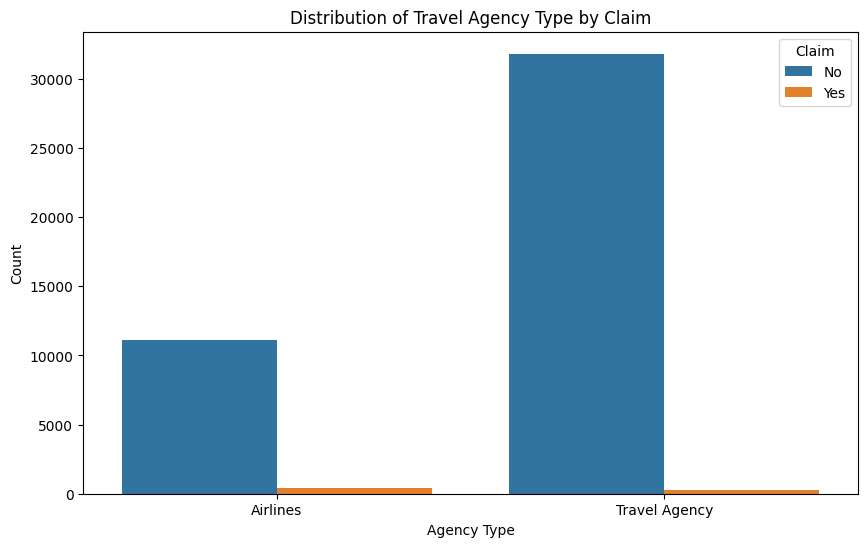

In [2718]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Agency Type', hue='Claim', data=df)
plt.title('Distribution of Travel Agency Type by Claim')
plt.xlabel('Agency Type')
plt.ylabel('Count')
plt.show()

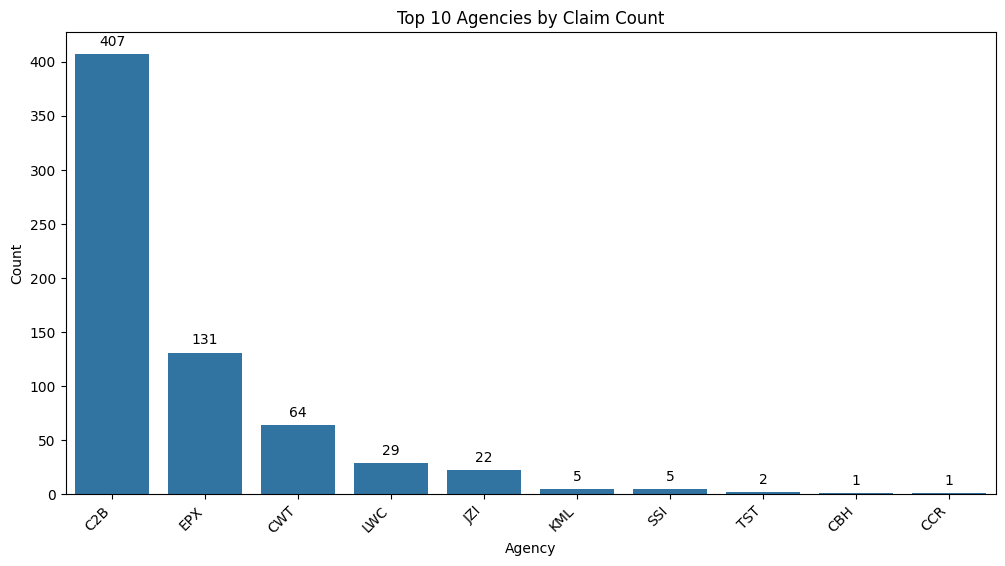

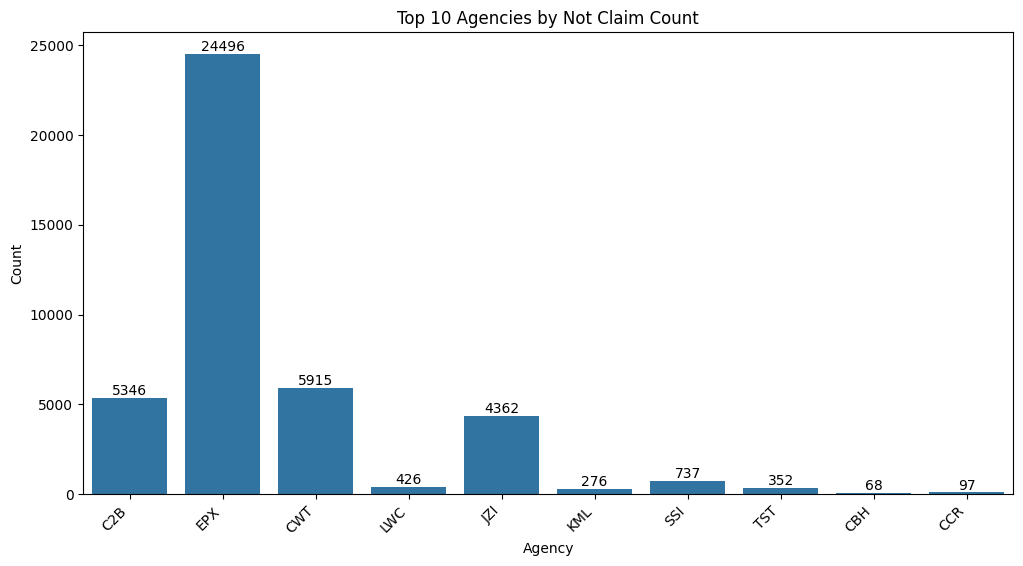

In [2719]:
# Menghitung jumlah klaim ('Yes') dan 'Not Claim' ('No') untuk setiap Agency
agency_claims = df.groupby(['Agency', 'Claim']).size().unstack(fill_value=0)

# Menyortir agency berdasarkan jumlah klaim ('Yes') dan memilih 10 terbesar
top_10_agencies = agency_claims.sort_values(by='Yes', ascending=False).head(10)

# Reset index untuk membuatnya lebih mudah digunakan dalam plot
top_10_agencies = top_10_agencies.reset_index()

# Plot pertama untuk 'Claim' (Yes)
plt.figure(figsize=(12, 6))
ax1 = sns.barplot(x='Agency', y='Yes', data=top_10_agencies)
plt.title('Top 10 Agencies by Claim Count')
plt.xlabel('Agency')
plt.ylabel('Count')

# Menambahkan anotasi jumlah di atas setiap batang
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width() / 2, height + 5, int(height), 
             ha="center", va="bottom", fontsize=10)
    
plt.xticks(rotation=45, ha='right')  # Putar label agensi agar lebih mudah dibaca
plt.show()

# Plot kedua untuk 'Not Claim' (No)
plt.figure(figsize=(12, 6))
ax2 = sns.barplot(x='Agency', y='No', data=top_10_agencies)
plt.title('Top 10 Agencies by Not Claim Count')
plt.xlabel('Agency')
plt.ylabel('Count')

# Menambahkan anotasi jumlah di atas setiap batang
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width() / 2, height + 5, int(height), 
             ha="center", va="bottom", fontsize=10)

plt.xticks(rotation=45, ha='right')  # Putar label agensi agar lebih mudah dibaca
plt.show()

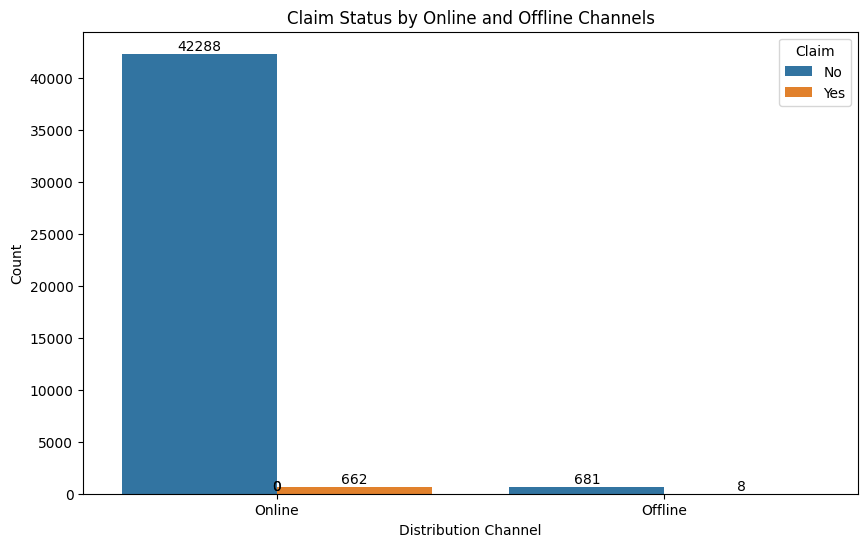

chi-square p-value between age and readmitted variable is 2.7433328984684555e-23


In [2720]:
# Membuat bar plot berkelompok
plt.figure(figsize=(10, 6))
ax =sns.countplot(x='Distribution Channel', hue='Claim', data=df)
plt.title('Claim Status by Online and Offline Channels')
plt.xlabel('Distribution Channel')
plt.ylabel('Count')


for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 1, int(height), 
            ha="center", va="bottom", fontsize=10)

plt.show()


contingency = pd.crosstab(df[column], df['Claim'])
c, p, dof, expected = chi2_contingency(contingency)
print('chi-square p-value between age and readmitted variable is', p)



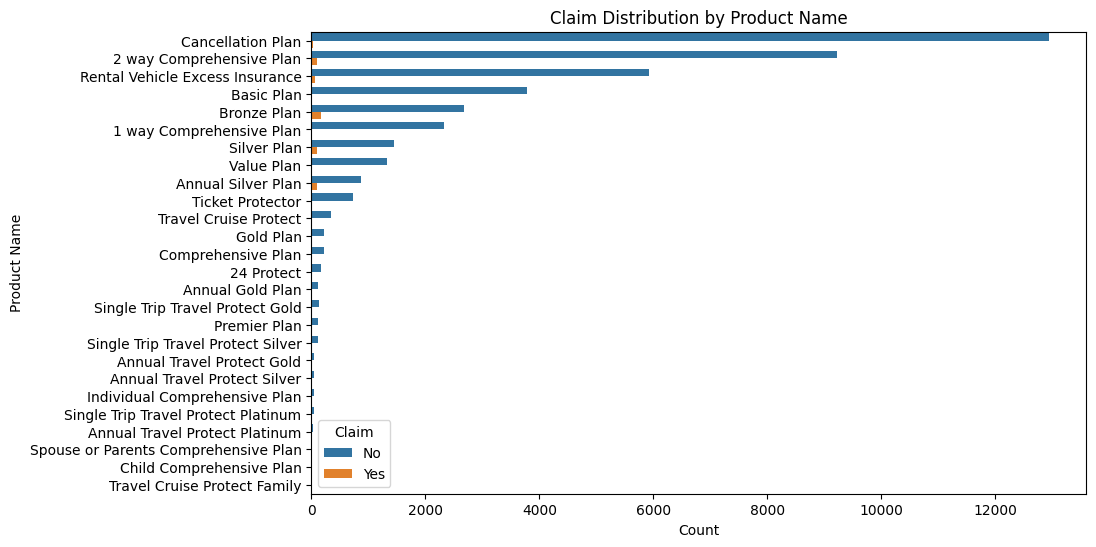

In [2721]:
# Klaim berdasarkan produk asuransi
plt.figure(figsize=(10, 6))
sns.countplot(y='Product Name', hue='Claim', data=df, order=df['Product Name'].value_counts().index)
plt.title('Claim Distribution by Product Name')
plt.xlabel('Count')
plt.ylabel('Product Name')
plt.show()


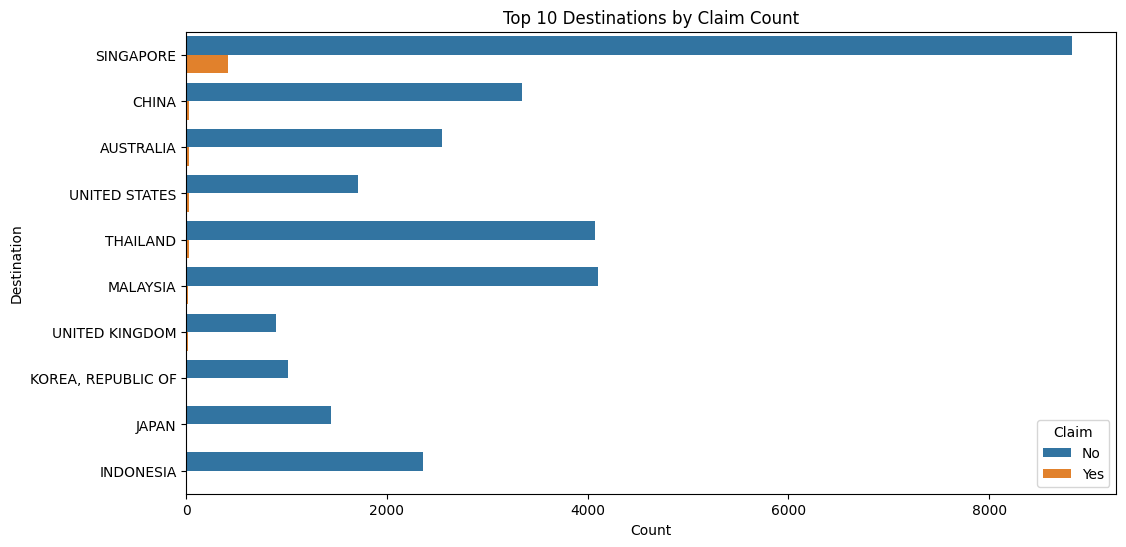

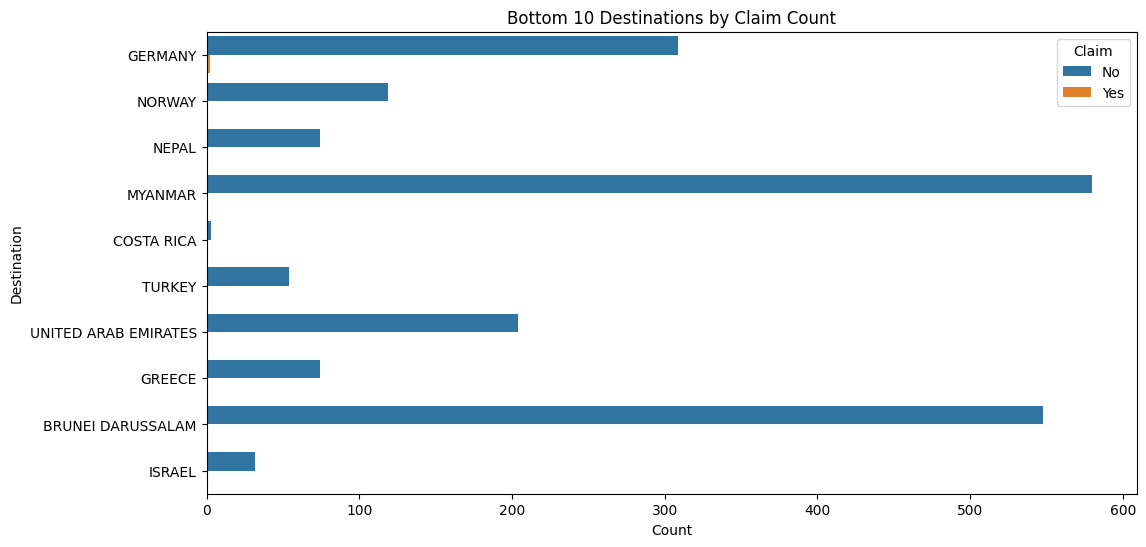

In [2722]:
# Menghitung jumlah klaim ('Yes') untuk setiap destinasi
destination_claims = df[df['Claim'] == 'Yes'].groupby('Destination').size().sort_values(ascending=False)

# Mengambil top 10 destinasi terbesar dan terkecil
top_10_destinations = destination_claims.head(10).index
bottom_10_destinations = destination_claims.tail(10).index

# Filter data untuk top 10 destinasi terbesar
df_top_10 = df[df['Destination'].isin(top_10_destinations)]

# Filter data untuk top 10 destinasi terkecil
df_bottom_10 = df[df['Destination'].isin(bottom_10_destinations)]

# Plot untuk top 10 destinasi terbesar
plt.figure(figsize=(12, 6))
sns.countplot(y='Destination', hue='Claim', data=df_top_10, order=top_10_destinations)
plt.title('Top 10 Destinations by Claim Count')
plt.xlabel('Count')
plt.ylabel('Destination')
plt.show()

# Plot untuk top 10 destinasi terkecil
plt.figure(figsize=(12, 6))
sns.countplot(y='Destination', hue='Claim', data=df_bottom_10, order=bottom_10_destinations)
plt.title('Bottom 10 Destinations by Claim Count')
plt.xlabel('Count')
plt.ylabel('Destination')
plt.show()

In [2723]:
df1 = df.groupby(by=["Destination"]).size().reset_index(name="counts")
df1.nlargest(15,['counts'])
df1['DestinationNew'] = np.where(df1['counts']>1090, df1['Destination'], 'Others')
fig = px.pie(df1, values='counts', names='DestinationNew', title='Destinations Popularity')
fig.show()

   Duration DurationGroup
0       365     >3 months
1         4       <1 week
2        19     2-3 weeks
3        20     2-3 weeks
4         8     1-2 weeks
5         2       <1 week
6        25     3-4 weeks
7        90    2-3 months
8         4       <1 week
9        24     3-4 weeks


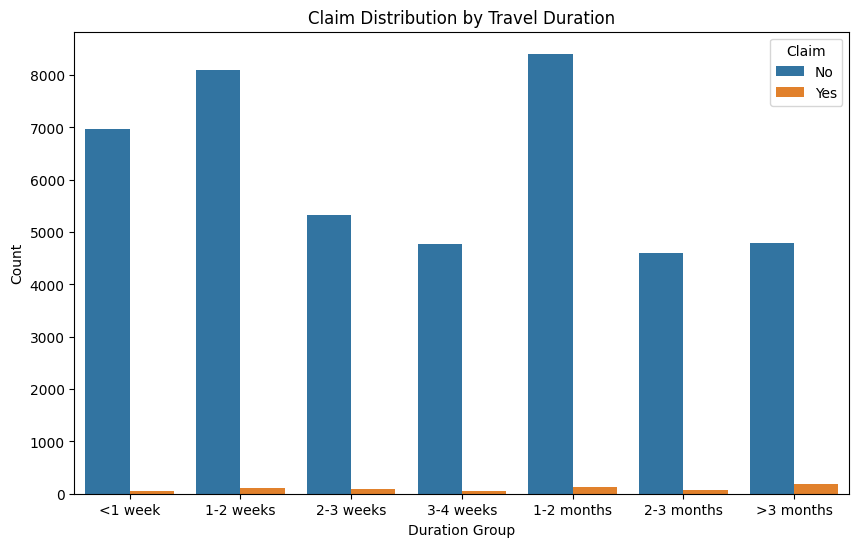

In [2724]:
bins = [0, 7, 14, 21, 30, 60, 100, 1000]  # Rentang durasi yang dikelompokkan
labels = ['<1 week', '1-2 weeks', '2-3 weeks', '3-4 weeks', '1-2 months', '2-3 months', '>3 months',]
df['DurationGroup'] = pd.cut(df['Duration'], bins=bins, labels=labels, right=False)

# Menampilkan pengelompokan
print(df[['Duration', 'DurationGroup']].head(10))
plt.figure(figsize=(10, 6))
sns.countplot(x='DurationGroup', hue='Claim', data=df)
plt.title('Claim Distribution by Travel Duration')
plt.xlabel('Duration Group')
plt.ylabel('Count')
plt.show()

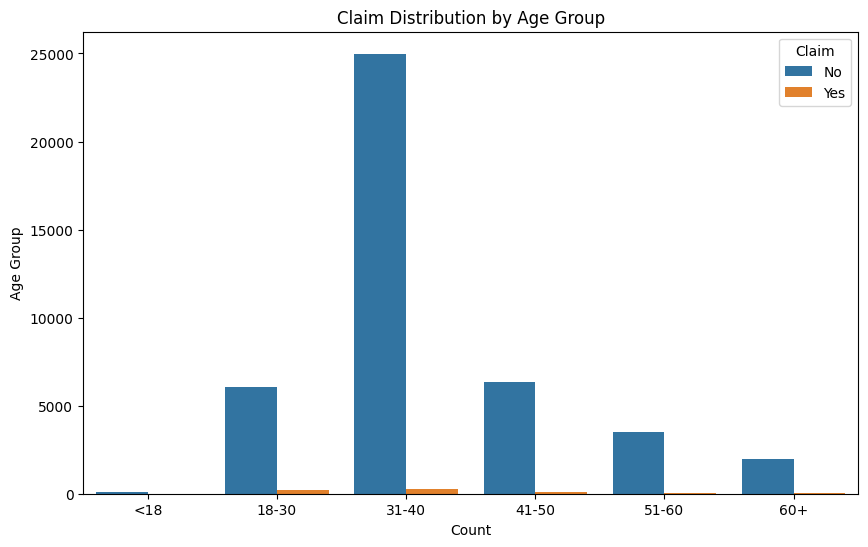

AgeGroup
31-40    25268
41-50     6424
18-30     6261
51-60     3568
60+       1992
<18        124
Name: count, dtype: int64

In [2725]:
# Membuat kelompok usia
bins = [0, 18, 30, 40, 50, 60, 100]
labels = ['<18', '18-30', '31-40', '41-50', '51-60', '60+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)

# Visualisasi klaim berdasarkan kelompok usia
plt.figure(figsize=(10, 6))
sns.countplot(x='AgeGroup', hue='Claim', data=df)
plt.title('Claim Distribution by Age Group')
plt.xlabel('Count')
plt.ylabel('Age Group')
plt.show()

total_age_claim = df['AgeGroup'].value_counts()
total_age_claim


   Duration DurationGroup
0       365     >3 months
1         4       <1 week
2        19     2-3 weeks
3        20     2-3 weeks
4         8     1-2 weeks
5         2       <1 week
6        25     3-4 weeks
7        90    2-3 months
8         4       <1 week
9        24     3-4 weeks


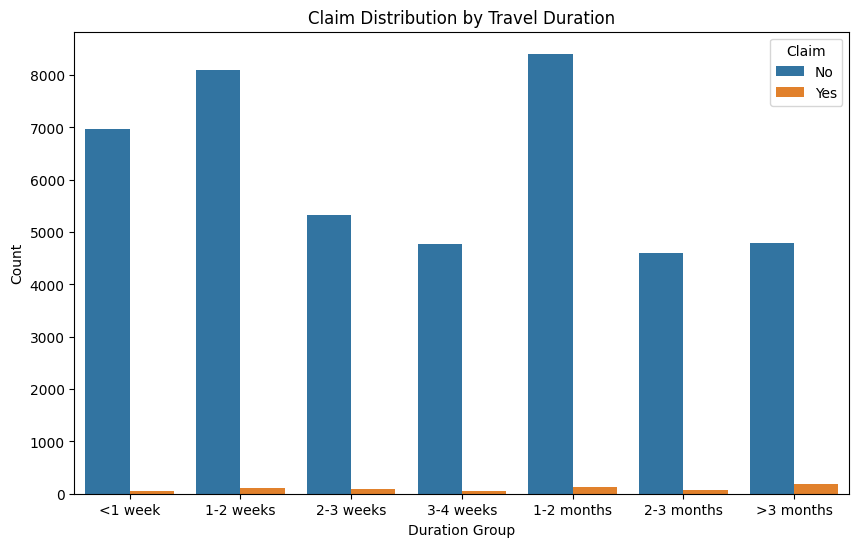

In [2726]:
bins = [0, 7, 14, 21, 30, 60, 100, 1000]  # Rentang durasi yang dikelompokkan
labels = ['<1 week', '1-2 weeks', '2-3 weeks', '3-4 weeks', '1-2 months', '2-3 months', '>3 months',]
df['DurationGroup'] = pd.cut(df['Duration'], bins=bins, labels=labels, right=False)

# Menampilkan pengelompokan
print(df[['Duration', 'DurationGroup']].head(10))
plt.figure(figsize=(10, 6))
sns.countplot(x='DurationGroup', hue='Claim', data=df)
plt.title('Claim Distribution by Travel Duration')
plt.xlabel('Duration Group')
plt.ylabel('Count')
plt.show()

kita bisa melihat bahwa jumlah claim pada customer yang melakukan perjalanan lebih dari 3 bulan lebih cenderung melakukan claim di bandingkan yang melakukan travel kurang dari 1 bulan

Jumlah customer yang melakukan claim paling banyak masih di dapatkan oleh C2B dan EPX dan jumlah not claim yang paling banyak itu di pegang oleh EPX dan juga CWT.

Namun kita bisa melihat bahwa dengan jumlah not claim dan claim. yang masih mendapatkan jumlah claim terbanyak dari agency itu ada di C2B dengan jumlah Not claim 5346 dan claim sebanyak 407 kita bisa melihat bahwa orang yang melakukan claim dari segi transaksi C2B masih memiliki selisih terkecil di bandingkan dengan yang lain terutama EPX

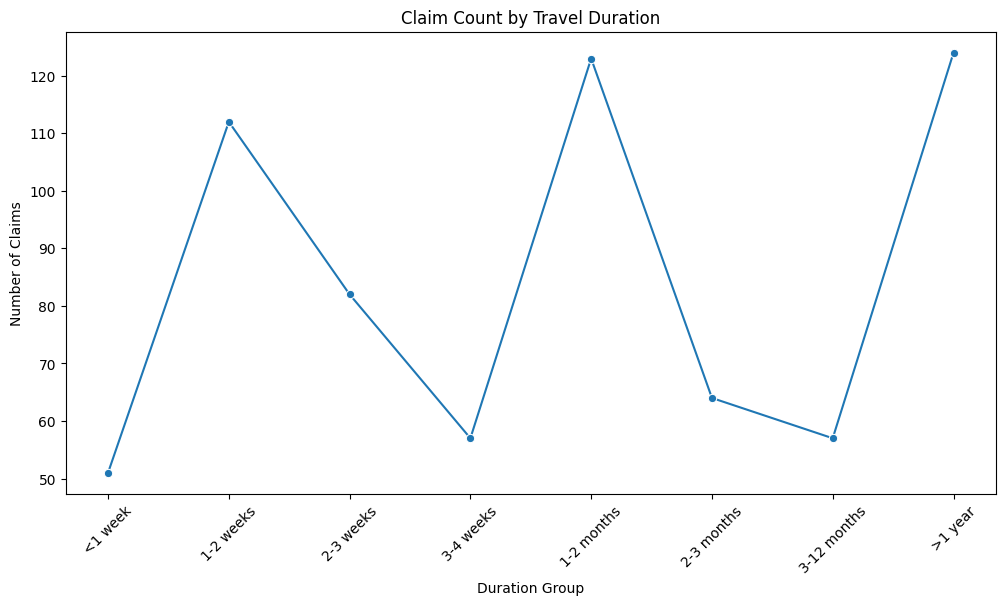

In [2727]:
# Mengelompokkan durasi perjalanan
bins = [0, 7, 14, 21, 30, 60, 100, 365, 1000]
labels = ['<1 week', '1-2 weeks', '2-3 weeks', '3-4 weeks', '1-2 months', '2-3 months', '3-12 months', '>1 year']
df['DurationGroup'] = pd.cut(df['Duration'], bins=bins, labels=labels, right=False)

# Menghitung jumlah klaim untuk setiap kelompok durasi
claims_by_duration = df[df['Claim'] == 'Yes'].groupby('DurationGroup').size().reset_index(name='Count')

# Membuat line chart
plt.figure(figsize=(12, 6))
sns.lineplot(x='DurationGroup', y='Count', data=claims_by_duration, marker='o')
plt.title('Claim Count by Travel Duration')
plt.xlabel('Duration Group')
plt.ylabel('Number of Claims')
plt.xticks(rotation=45)
plt.show()

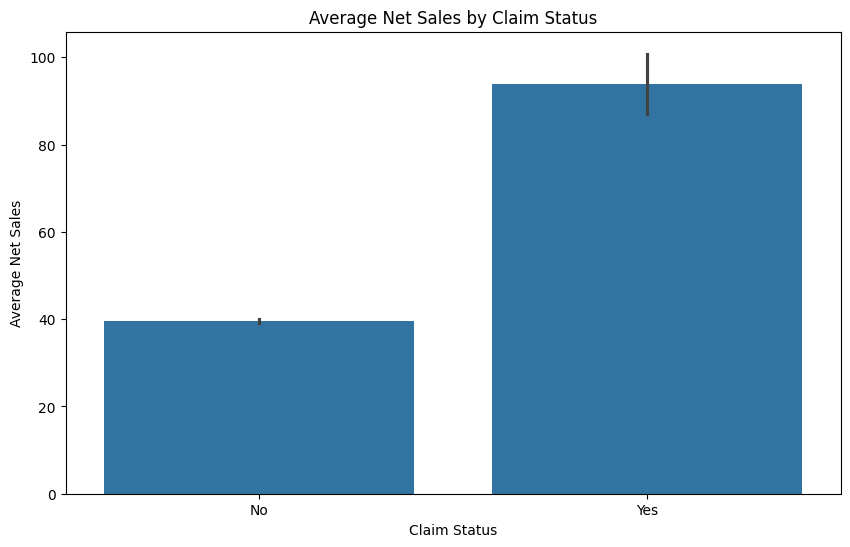

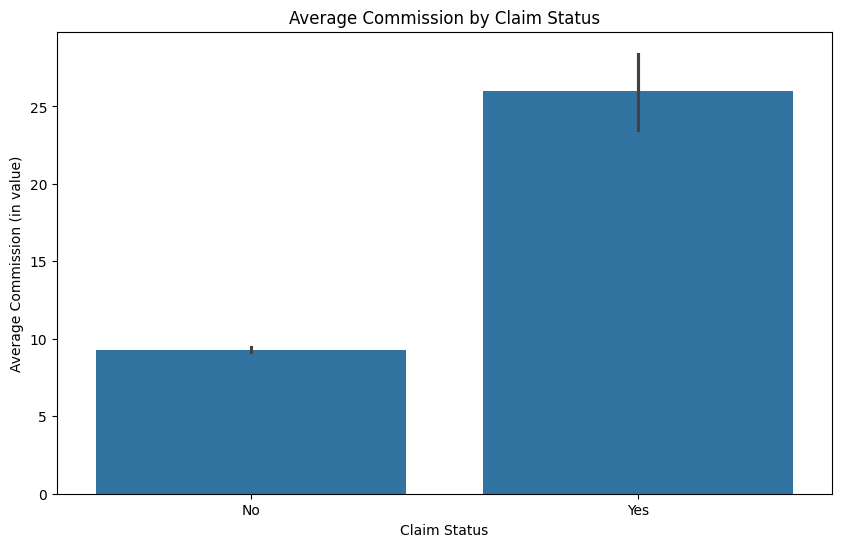

In [2729]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Claim', y='Net Sales', data=df)
plt.title('Average Net Sales by Claim Status')
plt.xlabel('Claim Status')
plt.ylabel('Average Net Sales')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Claim', y='Commision (in value)', data=df)
plt.title('Average Commission by Claim Status')
plt.xlabel('Claim Status')
plt.ylabel('Average Commission (in value)')
plt.show()


## *Data Imbalance*

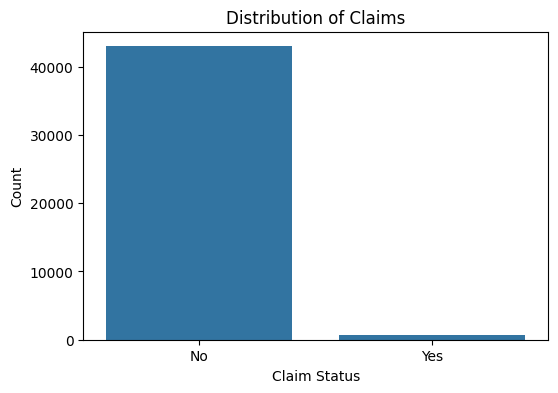

Claim
No     42969
Yes      670
Name: count, dtype: int64

In [2730]:
claim_distribution = df['Claim'].value_counts()
plt.figure(figsize=(6, 4))
sns.countplot(x='Claim', data=df)
plt.title('Distribution of Claims')
plt.xlabel('Claim Status')
plt.ylabel('Count')
plt.show()

claim_distribution

In [2731]:
# Memeriksa nilai NaN di dalam fitur
print(X.isna().sum())

# Memeriksa nilai NaN di dalam target
print(y.isna().sum())


Agency                  0
Agency Type             0
Distribution Channel    0
Product Name            0
Duration                0
Destination             0
Net Sales               0
Commision (in value)    0
Age                     0
DurationGroup           0
AgeGroup                0
dtype: int64
0


In [2732]:
# Menghitung jumlah nilai NaN pada kolom agegrup
nan_count = df['AgeGroup'].isna().sum()
print(f'Jumlah nilai NaN pada kolom agegrup: {nan_count}')


Jumlah nilai NaN pada kolom agegrup: 2


In [2733]:
# Menampilkan baris yang memiliki nilai NaN pada kolom agegrup
nan_rows = df[df['AgeGroup'].isna()]
print(nan_rows)


      Agency    Agency Type Distribution Channel           Product Name  \
37815    TST  Travel Agency              Offline  Travel Cruise Protect   
44319    TST  Travel Agency              Offline  Travel Cruise Protect   

       Duration Destination  Net Sales  Commision (in value)  Age Claim  \
37815        94    THAILAND      -30.0                  10.5    0    No   
44319        94    THAILAND       30.0                  10.5    0    No   

      DurationGroup AgeGroup  
37815    2-3 months      NaN  
44319    2-3 months      NaN  


In [2734]:
df = df.dropna(subset=['AgeGroup'])


## **Data Preparation**

In [2735]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43637 entries, 0 to 44327
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Agency                43637 non-null  object  
 1   Agency Type           43637 non-null  object  
 2   Distribution Channel  43637 non-null  object  
 3   Product Name          43637 non-null  object  
 4   Duration              43637 non-null  int64   
 5   Destination           43637 non-null  object  
 6   Net Sales             43637 non-null  float64 
 7   Commision (in value)  43637 non-null  float64 
 8   Age                   43637 non-null  int64   
 9   Claim                 43637 non-null  object  
 10  DurationGroup         43637 non-null  category
 11  AgeGroup              43637 non-null  category
dtypes: category(2), float64(2), int64(2), object(6)
memory usage: 3.7+ MB


1. Merubah fitur/kolom `AgeGroup` menjadi integer 0-5 dengan Ordinal Encoding:
Fitur ini adalah kelompok umur, dimana <18 akan dirubah menjadi 0, 18-30 menjadi 1, dan seterusnya hingga 60+ yang dirubah menjadi 5. Karena fitur ini memiliki urutan (ordinal), penggunaan Ordinal Encoding sesuai untuk mempertahankan hubungan urutan antar kelompok umur.
2. Merubah fitur/kolom `DurationGroup` menjadi integer 0-6 dengan Ordinal Encoding:
Fitur ini adalah kelompok durasi, dimana <1 week akan dirubah menjadi 0, 1-2 weeks menjadi 1, dan seterusnya hingga >3 months yang dirubah menjadi 6. Karena fitur ini menggambarkan lama durasi yang memiliki urutan (ordinal), penggunaan Ordinal Encoding sesuai untuk mengurutkan durasi dari yang paling singkat ke yang paling lama.
3. Merubah fitur/kolom `Agency` menggunakan Binary Encoding:
Fitur ini memiliki banyak nilai unik (nama-nama agen yang berbeda), dan tidak ada urutan yang jelas di antara nilai-nilai tersebut. Menggunakan One Hot Encoding pada fitur ini akan menghasilkan terlalu banyak fitur baru, sehingga Binary Encoding dipilih untuk menjaga representasi yang lebih kompak dan efisien.
4. Merubah fitur/kolom `Product Name` menggunakan Binary Encoding:
Sama seperti Agency, fitur Product Name juga memiliki banyak nilai unik (nama-nama produk), dan tidak ada urutan di antara nilai-nilai tersebut. Oleh karena itu, Binary Encoding digunakan untuk fitur ini.
5. Merubah fitur/kolom `Destination` menggunakan Binary Encoding:
Fitur Destination berisi berbagai destinasi yang juga tidak memiliki urutan atau hierarki. Menggunakan Binary Encoding akan membantu menjaga jumlah fitur tetap terkendali sambil tetap mempertahankan informasi dari destinasi yang berbeda.
6. Merubah fitur/kolom `Agency Type` menggunakan One Hot Encoding:
Fitur ini memiliki nilai unik yang sedikit (misalnya, "Travel Agency" dan "Airlines") dan tidak memiliki urutan tertentu. Oleh karena itu, One Hot Encoding digunakan untuk membuat fitur dummy yang mewakili setiap jenis agensi tanpa mengasumsikan urutan.
7. Merubah fitur/kolom `Distribution Channel` menggunakan One Hot Encoding:
Fitur ini menggambarkan saluran distribusi (misalnya, "Offline" dan "Online") yang juga tidak memiliki urutan. One Hot Encoding digunakan untuk menciptakan fitur dummy untuk setiap saluran distribusi.v

In [2736]:
ordinal_mapping = [
    {'col' : 'AgeGroup',
     'mapping' : {
        '<18' : 0,
        '18-30' : 1,
        '31-40' : 2,
        '41-50' : 3,
        '51-60' : 4,
        '60+' : 5
    }},
    {'col' : 'DurationGroup',
     'mapping' : {
        '<1 week' : 0,
        '1-2 weeks' : 1,
        '2-3 weeks' : 2,
        '3-4 weeks' : 3,
        '1-2 months' : 4,
        '2-3 months' : 5,
        '>3 months' : 6
    }}
]

In [2737]:
# Change Claim value to numerical

df.Claim = df.Claim.map(dict(Yes=1, No=0))

In [2738]:
# One hot encoding for Agency Type and Distribution Channel

one_hot_encoding = OneHotEncoder()
one_hot_var = ['Agency Type', 'Distribution Channel']

# Binary encoding for Agency, Product Name, and Destination

binary_encoding = ce.BinaryEncoder()

binary_var = ['Agency', 'Product Name', 'Destination'] 

ordinal_encoding = ce.OrdinalEncoder(mapping = ordinal_mapping)
ordinal_var =['AgeGroup', 'DurationGroup']

transformer = ColumnTransformer([
                                ('one hot', one_hot_encoding, one_hot_var),
                                ('ordinal', ordinal_encoding, ordinal_var),
                                ('binary', binary_encoding, binary_var)
                                ], remainder = 'passthrough')

In [2739]:
# Fit and transform the data
X_transformed = transformer.fit_transform(X)

# Convert to a DataFrame to inspect the data
X_transformed_df = pd.DataFrame(X_transformed)

# Check for any non-numeric columns or values
print(X_transformed_df.dtypes)
print(X_transformed_df.head())


0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
18    float64
19    float64
20    float64
21    float64
22    float64
23    float64
24    float64
25    float64
26    float64
dtype: object
    0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
0  1.0  0.0  0.0  1.0  4.0 -1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   
1  0.0  1.0  0.0  1.0  2.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   
2  1.0  0.0  0.0  1.0  1.0  2.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0   
3  0.0  1.0  0.0  1.0  4.0  2.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0   
4  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0   

    15   16   17   18   19   20   21   22     23     24    25    26  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  365.0  216.0  

In [2740]:
# Ensure no strings remain in the DataFrame
non_numeric_columns = X_transformed_df.select_dtypes(include=['object']).columns
if len(non_numeric_columns) > 0:
    print(f"Columns still containing non-numeric data: {non_numeric_columns}")
else:
    print("All columns are numeric.")


All columns are numeric.


In [2802]:
# Fit the transformer and transform the dataset
X_transformed = pd.DataFrame(transformer.fit_transform(df))
X_transformed.columns = transformer.get_feature_names_out()
X_transformed


,one hot__Agency Type_Airlines,one hot__Agency Type_Travel Agency,one hot__Distribution Channel_Offline,one hot__Distribution Channel_Online,ordinal__AgeGroup,ordinal__DurationGroup,binary__Agency_0,binary__Agency_1,binary__Agency_2,binary__Agency_3,binary__Product Name_0,binary__Product Name_1,binary__Product Name_2,binary__Product Name_3,binary__Product Name_4,binary__Destination_0,binary__Destination_1,binary__Destination_2,binary__Destination_3,binary__Destination_4,binary__Destination_5,binary__Destination_6,binary__Destination_7,remainder__Duration,remainder__Net Sales,remainder__Commision (in value),remainder__Age,remainder__Claim
0,1.0,0.0,0.0,1.0,4.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,365.0,216.0,54.00,57.0,0.0
1,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,10.0,0.00,33.0,0.0
2,1.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,19.0,22.0,7.70,26.0,0.0
3,0.0,1.0,0.0,1.0,4.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,20.0,112.0,0.00,59.0,0.0
4,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,16.0,4.00,28.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43632,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,14.0,30.0,0.00,36.0,1.0
43633,0.0,1.0,0.0,1.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,17.0,79.2,47.52,47.0,0.0
43634,0.0,1.0,1.0,0.0,3.0,5.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,64.0,30.0,10.50,50.0,0.0
43635,0.0,1.0,0.0,1.0,2.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,51.0,36.0,0.00,36.0,0.0


In [2742]:
transformer.get_feature_names_out()

array(['one hot__Agency Type_Airlines',
       'one hot__Agency Type_Travel Agency',
       'one hot__Distribution Channel_Offline',
       'one hot__Distribution Channel_Online', 'ordinal__AgeGroup',
       'ordinal__DurationGroup', 'binary__Agency_0', 'binary__Agency_1',
       'binary__Agency_2', 'binary__Agency_3', 'binary__Product Name_0',
       'binary__Product Name_1', 'binary__Product Name_2',
       'binary__Product Name_3', 'binary__Product Name_4',
       'binary__Destination_0', 'binary__Destination_1',
       'binary__Destination_2', 'binary__Destination_3',
       'binary__Destination_4', 'binary__Destination_5',
       'binary__Destination_6', 'binary__Destination_7',
       'remainder__Duration', 'remainder__Net Sales',
       'remainder__Commision (in value)', 'remainder__Age'], dtype=object)

In [2743]:
X = df.drop(columns=["Claim"])
Y = df["Claim"]

In [2744]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    stratify=Y,
    test_size=0.2, 
    random_state=2022
)

In [2745]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,stratify=Y,test_size=0.2,random_state=42)

## Modeling dan Evaluation

In [2746]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgb = LGBMClassifier()

## Model Benchmarking : K- FOld

In [2747]:
models = [logreg,knn,dt,rf,xgb,lgb]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

[LightGBM] [Info] Number of positive: 429, number of negative: 27498
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 27927, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015361 -> initscore=-4.160412
[LightGBM] [Info] Start training from score -4.160412
[LightGBM] [Info] Number of positive: 429, number of negative: 27498
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 865
[LightGBM] [Info] Number of data points in the train set: 27927, number of used features: 26
[LightGBM] [Info] [binar

,mean roc_auc,sdev
model,,
LightGBM,0.801989,0.025951
Logistic Regression,0.799616,0.013068
XGBoost,0.778954,0.032454
Random Forest,0.703833,0.018603
KNN,0.587416,0.010225
Decision Tree,0.534659,0.011593


Bisa kita lihat bahwa LightGBM adalah yang terbaik untuk roc_aucnya dari setiap model yang di gunakan

## Model benchmarking : Test Data

In [2748]:
models = [logreg,knn,dt,rf,xgb,lgb]
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    x_train,x_test
    
    estimator.fit(x_train,y_train)
    return(estimator,estimator.predict(x_test),x_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM']):
    estimator,y_pred,x_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(x_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      8594
           1       0.00      0.00      0.00       134

    accuracy                           0.98      8728
   macro avg       0.49      0.50      0.50      8728
weighted avg       0.97      0.98      0.98      8728

KNN 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      8594
           1       0.00      0.00      0.00       134

    accuracy                           0.98      8728
   macro avg       0.49      0.50      0.50      8728
weighted avg       0.97      0.98      0.98      8728

Decision Tree 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      8594
           1       0.06      0.07      0.06       134

    accuracy                           0.97      8728
   macro avg       0.52      0.53      0.52      8728
weighted avg       0.97      0

,roc_auc score
model,
LightGBM,0.833248
Logistic Regression,0.826609
XGBoost,0.804126
Random Forest,0.739404
KNN,0.600599
Decision Tree,0.535243


kita bisa lihat bahwa dari kedua Model Benchmark model LightGBM adalah yang terunggul performanya pada test data mau pun K-Fold.

Jadi sekarang saya akan mencoba melakukan oversampling untuk model LightGBM  untuk melihat apakah saya dapat mendapatkan hasil yang lebih baik lagi.

Reference : https://lightgbm.readthedocs.io/en/latest/index.html

In [2749]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [2750]:
K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=2022)

In [2751]:
data = X_train
target = Y_train

In [2752]:
from lightgbm import LGBMClassifier

train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_oversampling = []
validation_errors_with_oversampling = []

for train_index, val_index in kf.split(data, target):
    
    # split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    Y_train, Y_val = target.iloc[train_index], target.iloc[val_index]
    
#     print(len(X_val), (len(X_train) + len(X_val)))
    ros = RandomOverSampler()

    X_ros, Y_ros = ros.fit_resample(X_train, Y_train)

    # instantiate model
    lgbm = LGBMClassifier()
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',lgbm)
    ])

    #calculate errors
    train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train, Y_train, X_val, Y_val, estimator)
    train_error_with_oversampling, val_error_with_oversampling = calc_metrics(X_ros, Y_ros, X_val, Y_val, estimator)
    
    # append to appropriate list
    train_errors_without_oversampling.append(train_error_without_oversampling)
    validation_errors_without_oversampling.append(val_error_without_oversampling)
    
    train_errors_with_oversampling.append(train_error_with_oversampling)
    validation_errors_with_oversampling.append(val_error_with_oversampling)

[LightGBM] [Info] Number of positive: 483, number of negative: 30935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 865
[LightGBM] [Info] Number of data points in the train set: 31418, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015373 -> initscore=-4.159627
[LightGBM] [Info] Start training from score -4.159627
[LightGBM] [Info] Number of positive: 30935, number of negative: 30935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 776
[LightGBM] [Info] Number of data points in the train set: 61870, number of used features: 26
[LightGBM] [Info] [bin

## Evaluation Matrics without oversampling


In [2753]:
listItem = []

for tr,val in zip(train_errors_without_oversampling,validation_errors_without_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.986186,0.984245,0.982652,0.788444,0.588622,0.496030,0.101449,0.0,1.000000,0.0
1,0.985709,0.984532,0.984869,0.797285,0.563835,0.496103,0.072464,0.0,0.972222,0.0
2,0.986632,0.984532,0.984786,0.803980,0.612013,0.496103,0.130435,0.0,1.000000,0.0
3,0.986154,0.983959,0.985217,0.818007,0.586905,0.495957,0.099585,0.0,0.979592,0.0
4,0.985932,0.984532,0.984421,0.809273,0.573082,0.496103,0.082988,0.0,1.000000,0.0
5,0.986218,0.984245,0.985141,0.808667,0.588804,0.496030,0.101660,0.0,1.000000,0.0
6,0.985868,0.984532,0.984051,0.836962,0.569514,0.496103,0.078838,0.0,1.000000,0.0
7,0.985932,0.984245,0.983532,0.818050,0.573082,0.496030,0.082988,0.0,1.000000,0.0
8,0.986345,0.984532,0.984079,0.816507,0.595622,0.496103,0.109959,0.0,1.000000,0.0
9,0.985868,0.984814,0.980734,0.862267,0.572773,0.496174,0.082816,0.0,0.975610,0.0


## Evaluation metric with oversampling

In [2754]:
listItem = []

for tr,val in zip(train_errors_with_oversampling,validation_errors_with_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.934799,0.863076,0.975120,0.763569,0.934629,0.517027,0.985809,0.547170,0.894547,0.060041
1,0.934605,0.868519,0.974637,0.758935,0.934457,0.515415,0.982059,0.490566,0.896932,0.056769
2,0.936884,0.875967,0.975825,0.772553,0.936713,0.510939,0.988880,0.396226,0.895731,0.049763
3,0.929241,0.887425,0.974072,0.802005,0.929090,0.530334,0.975433,0.500000,0.892940,0.068702
4,0.937290,0.874821,0.973520,0.782600,0.937102,0.519518,0.991886,0.481481,0.894241,0.059770
5,0.936805,0.881123,0.974560,0.818643,0.936626,0.523825,0.990012,0.481481,0.894794,0.062954
6,0.934251,0.872529,0.975474,0.827789,0.934073,0.525054,0.986294,0.555556,0.893313,0.066519
7,0.930162,0.869378,0.975135,0.795609,0.930018,0.521170,0.975562,0.537037,0.894355,0.063043
8,0.931310,0.878545,0.975828,0.820954,0.931160,0.532928,0.978019,0.592593,0.894460,0.073733
9,0.931924,0.869341,0.975991,0.843776,0.931734,0.531213,0.984646,0.660377,0.890725,0.073996


Tanpa Oversampling: Model memiliki akurasi yang tinggi tetapi recall yang sangat rendah, menunjukkan bahwa model tidak mampu mendeteksi klaim positif dengan baik. Ini bisa menjadi masalah jika klaim positif adalah target penting dari model.

Dengan Oversampling: Setelah menggunakan oversampling , recall pada data pengujian meningkat secara signifikan, yang berarti model lebih baik dalam mendeteksi klaim positif. Meskipun ada penurunan kecil dalam precision, ini adalah hasil yang diharapkan dalam upaya meningkatkan recall pada dataset yang tidak seimbang.

Classification reports without oversampling


In [2755]:
for rep in validation_errors_without_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3438
           1       0.00      0.00      0.00        53

    accuracy                           0.98      3491
   macro avg       0.49      0.50      0.50      3491
weighted avg       0.97      0.98      0.98      3491

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3438
           1       0.00      0.00      0.00        53

    accuracy                           0.98      3491
   macro avg       0.49      0.50      0.50      3491
weighted avg       0.97      0.98      0.98      3491

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3438
           1       0.00      0.00      0.00        53

    accuracy                           0.98      3491
   macro avg       0.49      0.50      0.50      3491
weighted avg       0.97      0.98      0.98      3491

              preci

Classification report with oversampling

In [2756]:
for rep in validation_errors_with_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.99      0.87      0.93      3438
           1       0.06      0.55      0.11        53

    accuracy                           0.86      3491
   macro avg       0.53      0.71      0.52      3491
weighted avg       0.98      0.86      0.91      3491

              precision    recall  f1-score   support

           0       0.99      0.87      0.93      3438
           1       0.06      0.49      0.10        53

    accuracy                           0.87      3491
   macro avg       0.52      0.68      0.52      3491
weighted avg       0.98      0.87      0.92      3491

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      3438
           1       0.05      0.40      0.09        53

    accuracy                           0.88      3491
   macro avg       0.52      0.64      0.51      3491
weighted avg       0.98      0.88      0.92      3491

              preci

Model Tanpa Oversampling : Model sangat bias terhadap kelas negatif, dengan hampir tidak ada prediksi benar untuk kelas positif. Ini biasa terjadi pada dataset yang sangat tidak seimbang.

Model Dengan Beberapa Teknik Penyesuaian : Ada peningkatan dalam recall dan F1-score untuk kelas positif, menunjukkan bahwa model mulai menangkap lebih banyak kasus positif, meskipun precision masih rendah. Ini menunjukkan bahwa model menjadi lebih baik dalam mendeteksi kelas positif tetapi mungkin masih perlu penyempurnaan lebih lanjut untuk mengurangi false positives.

## Hyperparameter Tuning

In [2757]:
lgbm = LGBMClassifier()
ros = RandomOverSampler(random_state=42)

estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',lgbm)
])

In [2758]:
hyperparam_space = [{
    'model__max_bin': [255, 300],
    'model__num_leaves': [31, 51],
    'model__min_data_in_leaf': [20, 40],
    'model__num_iterations': [100, 150],
    'model__learning_rate': [0.1, 0.05],
    'model__random_state': [42]
}]


default hyperparameter LGBM => `max_bin` = 255, `num_leaves` = 31, `min_data_in_leaf` = 20, `num_iterations` = 100, `learning_rate` = 0.1

In [2759]:
grid = GridSearchCV(estimator, n_jobs=-1, param_grid=hyperparam_space, scoring='roc_auc', cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))

In [2760]:
grid.fit(X_train,Y_train)
print(grid.best_score_)
print(grid.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 30936, number of negative: 30936
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 842
[LightGBM] [Info] Number of data points in the train set: 61872, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0.8158194306534572
{'model__learning_rate': 0.05, 'model__max_bin': 300, 'model__min_data_in_leaf': 20, 'model__num_iterations': 100, 'model__num_leaves': 31, 'model__random_state': 42}


Hyperparameter terbaik LGBM dari hasil Gridsearch => `max_bin` = 300, `num_leaves` = 31, `min_data_in_leaf` = 20, `num_iterations` = 100, `learning_rate` = 0.5

untuk hyperparameter hanya Maz_bin dan learning rate yang valuenya bisa di ubah lagi, dimana max_bin dan learning_rate dapat di perkecil lagi untuk mendapatkan value terbaik

In [2761]:
best_model = grid.best_estimator_
best_model.fit(x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 34373, number of negative: 34373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 68746, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot', OneHotEncoder(),
                                                  ['Agency Type',
                                                   'Distribution Channel']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'AgeGroup',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': <18      0
18-30    1
31-40    2
41-50    3
51-60    4
60+      5
dtype: int64},
                                                                          {'col': 'DurationGroup',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': <1 week       0
1-2 weeks     1
2-3 weeks     2
3-4 weeks     3
1-2 months    4
2-3 months    5
>3 months     6
dtype: int64}]),
                                                  ['AgeGroup',
                                                   'DurationGroup']),
                                                 ('binary', BinaryEncoder(),
                                                  ['Agency', 'Product Name',
                                                   'Destination'])])),
                ('model',
                 LGBMClassifier(learning_rate=0.05, max_bin=300,
                                min_data_in_leaf=20, num_iterations=100,
                                random_state=42))])

In [2762]:
estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',lgbm)
])
estimator.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 34373, number of negative: 34373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 68746, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot', OneHotEncoder(),
                                                  ['Agency Type',
                                                   'Distribution Channel']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'AgeGroup',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': <18      0
18-30    1
31-40    2
41-50    3
51-60    4
60+      5
dtype: int64},
                                                                          {'col': 'DurationGroup',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': <1 week       0
1-2 weeks     1
2-3 weeks     2
3-4 weeks     3
1-2 months    4
2-3 months    5
>3 months     6
dtype: int64}]),
                                                  ['AgeGroup',
                                                   'DurationGroup']),
                                                 ('binary', BinaryEncoder(),
                                                  ['Agency', 'Product Name',
                                                   'Destination'])])),
                ('model', LGBMClassifier())])

In [2763]:
y_pred_default = estimator.predict(x_test)
y_pred_proba_default = estimator.predict_proba(x_test)
y_pred_tuned = best_model.predict(x_test)
y_pred_proba_tuned = best_model.predict_proba(x_test)

roc_auc_default = roc_auc_score(y_test, y_pred_proba_default[:,1])
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

print('ROC AUC Score Default LGBM : ', roc_auc_default)
print('ROC AUC Score Tuned LGBM : ', roc_auc_tuned)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
ROC AUC Score Default LGBM :  0.8232040576730033
ROC AUC Score Tuned LGBM :  0.8543095842639258


Setelah kita melakukan hyperparameter ke model LGBM kita bisa melihat adanya peningkatan pada ROC AUC.

In [2764]:
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default LGBM : \n', report_default)
print('Classification Report Tuned LGBM : \n', report_tuned)

Classification Report Default LGBM : 
               precision    recall  f1-score   support

           0       0.99      0.88      0.93      8594
           1       0.07      0.58      0.12       134

    accuracy                           0.87      8728
   macro avg       0.53      0.73      0.53      8728
weighted avg       0.98      0.87      0.92      8728

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      8594
           1       0.06      0.69      0.12       134

    accuracy                           0.84      8728
   macro avg       0.53      0.77      0.51      8728
weighted avg       0.98      0.84      0.90      8728



Model Default LGBM:

Sangat baik dalam memprediksi kelas negatif tetapi sangat buruk dalam memprediksi kelas positif, seperti yang ditunjukkan oleh precision dan F1-Score yang rendah untuk kelas 1.
Model ini menunjukkan akurasi tinggi dan F1-Score yang baik untuk kelas negatif, tetapi hampir tidak berguna dalam mendeteksi kelas positif.

Model Tuned LGBM:

Penyetelan hyperparameter (tuning) telah meningkatkan recall untuk kelas positif, yang berarti model lebih baik dalam mendeteksi kasus positif. Namun, trade-offnya adalah penurunan sedikit pada recall dan F1-Score untuk kelas negatif.
Peningkatan pada recall kelas positif menunjukkan bahwa model yang di-tuning lebih mampu menangkap kasus positif, meskipun precision masih rendah, yang mengakibatkan F1-Score tetap rendah untuk kelas ini.

## Feature Importance

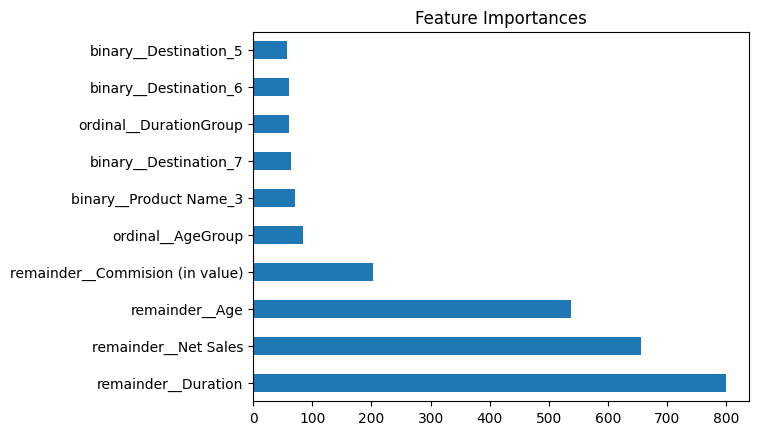

In [2766]:
coef1 = pd.Series(best_model['model'].feature_importances_, transformer.get_feature_names_out()).sort_values(ascending = False).head(10)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

Kita bisa melihat bahwa fitur/kolom remainder_duration, remainder_net Sales, remainder_age dan remainder_commision (in value) adalah yang paling penting.

In [2793]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you've already trained your LightGBM model and have predictions


In [2794]:
# Example predictions
y_true = y_test  # Replace with your actual y_test
y_pred = best_model.predict(X_test)  # Replace with your model's predictions
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_proba)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


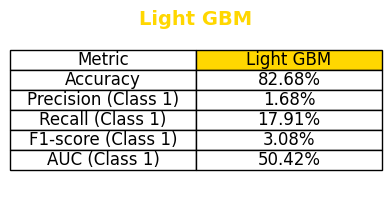

In [2795]:
# Plotting the metrics in a table
fig, ax = plt.subplots(figsize=(4, 2))  # Adjust the size as needed

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
tbl = ax.table(cellText=metrics.values, colLabels=metrics.columns, cellLoc='center', loc='center')

# Style the table
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 1.2)

# Highlight the header
tbl[0, 1].set_facecolor('#FFD700')

# Set title
ax.set_title('Light GBM', fontweight="bold", color='#FFD700', fontsize=14)

# Show plot
plt.show()


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


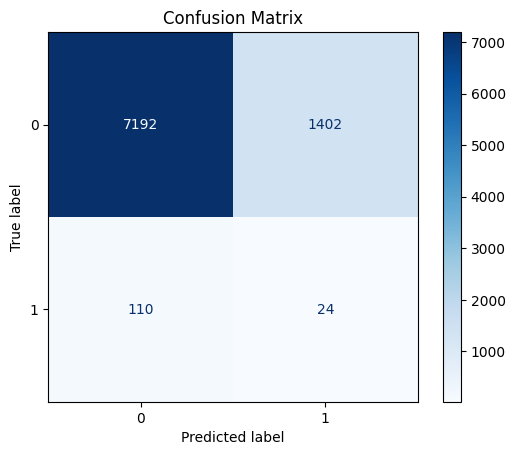

In [2796]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming best_model is your trained LightGBM model
y_pred = best_model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [2778]:
from sklearn.model_selection import learning_curve

In [2780]:
lgbm = LGBMClassifier(random_state=42)
pipeline = Pipeline([
    ('preprocess', transformer),
    ('model', lgbm)
])

In [2781]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Generate the learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipeline,
    X=X,  # Your features
    y=y,  # Your target
    cv=cv,
    scoring='accuracy',  # Or another scoring metric
    n_jobs=-1,  # Use all available cores
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 different training sizes
    verbose=0
)


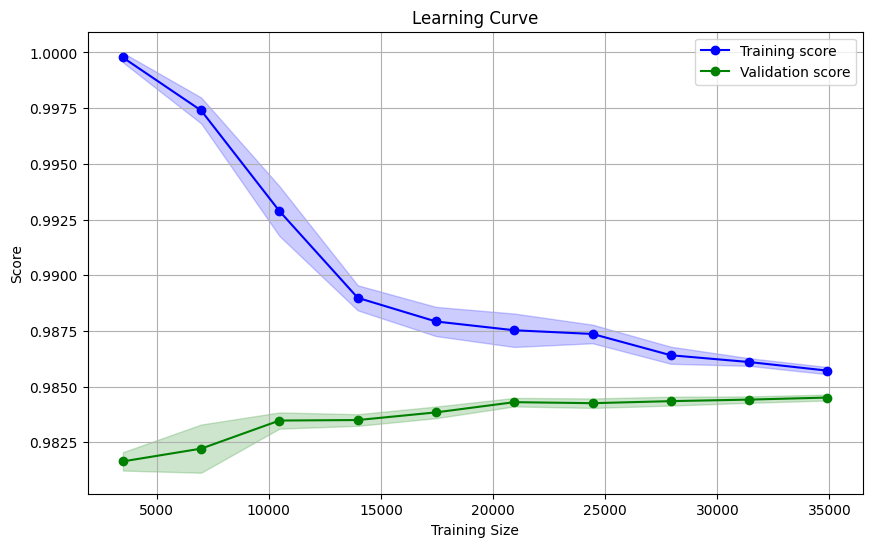

In [2782]:
# Calculate mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation score')

# Plot the standard deviation as a shaded area
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='green', alpha=0.2)

# Labels and title
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()


## Conclusion dan Recommendation

In [2801]:
print('Classification Report Tuned LGBM : \n', report_tuned)

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      8594
           1       0.06      0.69      0.12       134

    accuracy                           0.84      8728
   macro avg       0.53      0.77      0.51      8728
weighted avg       0.98      0.84      0.90      8728



## **CONCLUSION**


## Pengembangan Model Prediktif:

1. Model prediktif yang dikembangkan bertujuan untuk mengidentifikasi pemegang polis yang kemungkinan besar akan mengajukan klaim asuransi. Hal ini dilakukan dengan menggunakan beberapa algoritma machine learning, termasuk Logistic Regression, Decision Tree, K-Nearest Neighbor (KNN), LightGBM, Random Forest, dan XGBoost.
Di antara algoritma yang digunakan, LightGBM dengan tuning hyperparameter menunjukkan performa terbaik dengan peningkatan skor ROC-AUC yang signifikan. Ini menunjukkan bahwa model ini dapat memberikan prediksi yang lebih akurat terkait pemegang polis yang berisiko tinggi.
Evaluasi Kinerja Model:

2. Model dievaluasi menggunakan berbagai metrik seperti akurasi, precision, recall, F1-score, dan ROC-AUC. Meskipun hasil evaluasi menunjukkan kinerja yang baik, tantangan seperti ketidakseimbangan data masih menjadi perhatian utama.
Ketidakseimbangan data, di mana terdapat lebih banyak data pelanggan yang tidak mengajukan klaim dibandingkan dengan yang mengajukan klaim, dapat menyebabkan model menjadi bias terhadap kelas mayoritas. Ini mengurangi kemampuan model dalam memprediksi kelas minoritas (pelanggan yang mengajukan klaim) dengan akurat.
Selain itu, tantangan lain seperti overfitting, potensi bias, dan ketergantungan pada kualitas fitur juga teridentifikasi. Overfitting terjadi ketika model terlalu baik dalam menyesuaikan data pelatihan tetapi kurang mampu menangani data baru, sementara bias dan ketergantungan pada fitur dapat memengaruhi keandalan prediksi.
Manfaat Bisnis:

3. Model ini memberikan manfaat bisnis yang signifikan dengan memungkinkan perusahaan untuk mengalokasikan sumber daya secara lebih efisien kepada pelanggan yang dianggap berisiko tinggi.
Dengan memahami faktor-faktor yang berkontribusi pada kemungkinan pengajuan klaim, perusahaan dapat menyesuaikan produk dan layanan asuransi mereka untuk mengurangi risiko dan meningkatkan kepuasan pelanggan.
Selain itu, hasil dari model ini juga dapat digunakan untuk mengoptimalkan penetapan harga premi, sehingga menciptakan keseimbangan antara risiko dan profitabilitas.

## **Recommendation**

*Atasi Ketidakseimbangan Data:*

Disarankan untuk menerapkan teknik penanganan ketidakseimbangan data seperti SMOTE (Synthetic Minority Over-sampling Technique) atau ADASYN (Adaptive Synthetic Sampling). Teknik-teknik ini dapat membantu model dalam memprediksi kelas minoritas dengan lebih akurat, meningkatkan performa prediksi keseluruhan.

*Peningkatan Feature Engineering:*

Pertimbangkan untuk melakukan feature engineering lebih lanjut dengan menambahkan atau mentransformasi fitur-fitur yang ada. Penerapan pengetahuan spesifik industri dapat menghasilkan variabel baru yang lebih baik dalam merepresentasikan faktor-faktor yang mempengaruhi keputusan pengajuan klaim oleh pelanggan.

*Regularisasi dan Penyederhanaan Model:*

Untuk mengurangi risiko overfitting, gunakan metode regularisasi yang lebih kuat atau sederhanakan model dengan mengurangi jumlah fitur yang digunakan. Ini akan membantu model menjadi lebih robust dan mampu menangani data baru dengan lebih baik.

*Pengelolaan Bias:*

Lakukan evaluasi terhadap model untuk mengidentifikasi potensi bias, terutama terkait variabel demografis seperti usia, jenis kelamin, atau tujuan perjalanan. Jika bias ditemukan, terapkan langkah-langkah untuk mengoreksi bias tersebut, sehingga model menghasilkan prediksi yang adil dan tidak diskriminatif.

*Pengembangan Produk dan Layanan:*

Gunakan wawasan yang diperoleh dari analisis untuk mengembangkan produk asuransi yang lebih sesuai dengan profil risiko pelanggan. Misalnya, menawarkan paket asuransi khusus yang lebih menarik bagi segmen pelanggan dengan risiko rendah dapat membantu mengurangi kemungkinan pengajuan klaim.

*Strategi Pemasaran dan Layanan Pelanggan:*

Fokuskan upaya pemasaran dan layanan pada pelanggan yang diidentifikasi sebagai berisiko tinggi. Pendekatan proaktif ini dapat membantu meningkatkan kepuasan pelanggan dan mengurangi kemungkinan pengajuan klaim.

*Pemantauan dan Pemeliharaan Model:*

Tetapkan proses untuk secara rutin memantau performa model dan melakukan pelatihan ulang dengan data baru secara berkala. Hal ini penting untuk menjaga akurasi dan relevansi model dalam jangka panjang.

*Optimalisasi Penetapan Harga:*

Gunakan hasil dari model prediktif untuk mengoptimalkan strategi penetapan harga premi. Dengan menyesuaikan harga premi berdasarkan profil risiko pelanggan, perusahaan dapat meningkatkan profitabilitas sambil tetap menjaga daya tarik bagi pelanggan.